# Data Analysis of a Retail Store using Apache Spark

These tables come from the Cloudera Installation. A fictitious retail house with the following tables: customers, departments, categories, products, orders and order_items. In this notebook we will go through Spark SQL as well as Spark DF API based transformations and actions ranging from simple to quite complex.

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

In [3]:
# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6

In [5]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=23
np.random.set_state=23

## 1. Understanding the Data Set:
![](assets/cloudera-retail-db.png)
[source](https://www.cloudera.com/developers/get-started-with-hadoop-tutorial/exercise-1.html)
```
mysql> describe customers;
+-------------------+--------------+------+-----+---------+----------------+
| Field             | Type         | Null | Key | Default | Extra          |
+-------------------+--------------+------+-----+---------+----------------+
| customer_id       | int(11)      | NO   | PRI | NULL    | auto_increment |
| customer_fname    | varchar(45)  | NO   |     | NULL    |                |
| customer_lname    | varchar(45)  | NO   |     | NULL    |                |
| customer_email    | varchar(45)  | NO   |     | NULL    |                |
| customer_password | varchar(45)  | NO   |     | NULL    |                |
| customer_street   | varchar(255) | NO   |     | NULL    |                |
| customer_city     | varchar(45)  | NO   |     | NULL    |                |
| customer_state    | varchar(45)  | NO   |     | NULL    |                |
| customer_zipcode  | varchar(45)  | NO   |     | NULL    |                |
+-------------------+--------------+------+-----+---------+----------------+

mysql> describe departments;
+-----------------+-------------+------+-----+---------+----------------+
| Field           | Type        | Null | Key | Default | Extra          |
+-----------------+-------------+------+-----+---------+----------------+
| department_id   | int(11)     | NO   | PRI | NULL    | auto_increment |
| department_name | varchar(45) | NO   |     | NULL    |                |
+-----------------+-------------+------+-----+---------+----------------+

mysql> describe categories;
+------------------------+-------------+------+-----+---------+----------------+
| Field                  | Type        | Null | Key | Default | Extra          |
+------------------------+-------------+------+-----+---------+----------------+
| category_id            | int(11)     | NO   | PRI | NULL    | auto_increment |
| category_department_id | int(11)     | NO   |     | NULL    |                |
| category_name          | varchar(45) | NO   |     | NULL    |                |
+------------------------+-------------+------+-----+---------+----------------+

mysql> describe products;
+---------------------+--------------+------+-----+---------+----------------+
| Field               | Type         | Null | Key | Default | Extra          |
+---------------------+--------------+------+-----+---------+----------------+
| product_id          | int(11)      | NO   | PRI | NULL    | auto_increment |
| product_category_id | int(11)      | NO   |     | NULL    |                |
| product_name        | varchar(45)  | NO   |     | NULL    |                |
| product_description | varchar(255) | NO   |     | NULL    |                |
| product_price       | float        | NO   |     | NULL    |                |
| product_image       | varchar(255) | NO   |     | NULL    |                |
+---------------------+--------------+------+-----+---------+----------------+

mysql> describe orders;
+-------------------+-------------+------+-----+---------+----------------+
| Field             | Type        | Null | Key | Default | Extra          |
+-------------------+-------------+------+-----+---------+----------------+
| order_id          | int(11)     | NO   | PRI | NULL    | auto_increment |
| order_date        | datetime    | NO   |     | NULL    |                |
| order_customer_id | int(11)     | NO   |     | NULL    |                |
| order_status      | varchar(45) | NO   |     | NULL    |                |
+-------------------+-------------+------+-----+---------+----------------+

mysql> describe order_items;
+--------------------------+------------+------+-----+---------+----------------+
| Field                    | Type       | Null | Key | Default | Extra          |
+--------------------------+------------+------+-----+---------+----------------+
| order_item_id            | int(11)    | NO   | PRI | NULL    | auto_increment |
| order_item_order_id      | int(11)    | NO   |     | NULL    |                |
| order_item_product_id    | int(11)    | NO   |     | NULL    |                |
| order_item_quantity      | tinyint(4) | NO   |     | NULL    |                |
| order_item_subtotal      | float      | NO   |     | NULL    |                |
| order_item_product_price | float      | NO   |     | NULL    |                |
+--------------------------+------------+------+-----+---------+----------------+
```

## 2. Creating the Spark Session:

In [6]:
#os.environ['SPARK_HOME'] = 'D:\\Work\\spark-2.2.0-bin-hadoop2.6'
#os.environ['HADOOP_HOME'] = 'D:\\Work\\spark-2.2.0-bin-hadoop2.6'
os.environ['SPARK_HOME'] = 'D:\\Work\\spark-2.3.0-bin-hadoop2.7'
os.environ['HADOOP_HOME'] = 'D:\\Work\\spark-2.3.0-bin-hadoop2.7'

In [7]:
os.environ['SPARK_HOME']

'D:\\Work\\spark-2.3.0-bin-hadoop2.7'

In [8]:
spark = SparkSession.builder.master("local[2]").appName("retail_database_analysis").getOrCreate()

In [9]:
spark

In [10]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=retail_database_analysis>

In [11]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load the Data From Files Into DataFrames:

In [12]:
CUSTOMERS_DATA = 'data/retail_db/customers.csv'
DEPARTMENTS_DATA = 'data/retail_db/departments.csv'
CATEGORIES_DATA = 'data/retail_db/categories.csv'
PRODUCTS_DATA = 'data/retail_db/products.csv'
ORDERS_DATA = 'data/retail_db/orders.csv'
ORDER_ITEMS_DATA = 'data/retail_db/order_items.csv'

In [13]:
# define the schema, corresponding to a line in the csv data file for Customer
customers_schema = StructType([
    StructField('customer_id', IntegerType(), nullable=True),
    StructField('customer_fname', StringType(), nullable=True),
    StructField('customer_lname', StringType(), nullable=True),
    StructField('customer_email', StringType(), nullable=True),
    StructField('customer_password', StringType(), nullable=True),
    StructField('customer_street', StringType(), nullable=True),
    StructField('customer_city', StringType(), nullable=True),
    StructField('customer_state', StringType(), nullable=True),
    StructField('customer_zipcode', StringType(), nullable=True)])

In [14]:
departments_schema = StructType([
    StructField('department_id', IntegerType(), nullable=True),
    StructField('department_name', StringType(), nullable=True)])

In [15]:
categories_schema = StructType([
    StructField('category_id', IntegerType(), nullable=True),
    StructField('category_department_id', IntegerType(), nullable=True),
    StructField('category_name', StringType(), nullable=True)])

In [16]:
products_schema = StructType([
    StructField('product_id', IntegerType(), nullable=True),
    StructField('product_category_id', IntegerType(), nullable=True),
    StructField('product_name', StringType(), nullable=True),
    StructField('product_description', StringType(), nullable=True),
    StructField('product_price', FloatType(), nullable=True),
    StructField('product_image', StringType(), nullable=True)])

In [17]:
orders_schema = StructType([
    StructField('order_id', IntegerType(), nullable=True),
    StructField('order_date', StringType(), nullable=True),
    StructField('order_customer_id', IntegerType(), nullable=True),
    StructField('order_status', StringType(), nullable=True)])

In [18]:
order_items_schema = StructType([
    StructField('order_item_id', IntegerType(), nullable=True),
    StructField('order_item_order_id', IntegerType(), nullable=True),
    StructField('order_item_product_id', IntegerType(), nullable=True),
    StructField('order_item_quantity', IntegerType(), nullable=True),
    StructField('order_item_subtotal', FloatType(), nullable=True),
    StructField('order_item_product_price', FloatType(), nullable=True)])

In [19]:
# Load data
customers_df = spark.read.csv(path=CUSTOMERS_DATA, schema=customers_schema).cache()
departments_df = spark.read.csv(path=DEPARTMENTS_DATA, schema=departments_schema).cache()
categories_df = spark.read.csv(path=CATEGORIES_DATA, schema=categories_schema).cache()
products_df = spark.read.csv(path=PRODUCTS_DATA, schema=products_schema).cache()
orders_df = spark.read.csv(path=ORDERS_DATA, schema=orders_schema).cache()
order_items_df = spark.read.csv(path=ORDER_ITEMS_DATA, schema=order_items_schema).cache()

In [20]:
customers_df.createOrReplaceTempView("customers")

In [21]:
customers_df.select([col(choice) for choice in np.random.choice(customers_df.columns, size=5, replace=False)]).show(5)

+-----------+--------------+--------------------+----------------+-------------+
|customer_id|customer_state|     customer_street|customer_zipcode|customer_city|
+-----------+--------------+--------------------+----------------+-------------+
|          1|            TX|  6303 Heather Plaza|           78521|  Brownsville|
|          2|            CO|9526 Noble Embers...|           80126|    Littleton|
|          3|            PR|3422 Blue Pioneer...|           00725|       Caguas|
|          4|            CA|  8324 Little Common|           92069|   San Marcos|
|          5|            PR|10 Crystal River ...|           00725|       Caguas|
+-----------+--------------+--------------------+----------------+-------------+
only showing top 5 rows



In [22]:
departments_df.createOrReplaceTempView("departments")

In [23]:
departments_df.show(5)

+-------------+---------------+
|department_id|department_name|
+-------------+---------------+
|            2|        Fitness|
|            3|       Footwear|
|            4|        Apparel|
|            5|           Golf|
|            6|       Outdoors|
+-------------+---------------+
only showing top 5 rows



In [24]:
categories_df.createOrReplaceTempView("categories")

In [25]:
categories_df.show(5)

+-----------+----------------------+-------------------+
|category_id|category_department_id|      category_name|
+-----------+----------------------+-------------------+
|          1|                     2|           Football|
|          2|                     2|             Soccer|
|          3|                     2|Baseball & Softball|
|          4|                     2|         Basketball|
|          5|                     2|           Lacrosse|
+-----------+----------------------+-------------------+
only showing top 5 rows



In [26]:
products_df.createOrReplaceTempView("products")

In [27]:
products_df.show(5)

+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|               null|        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|               null|       129.99|http://images.acm...|
|         3|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         4|                  2|Under Armour Men'...|               null|        89.99|http://images.acm...|
|         5|                  2|Riddell Youth Rev...|               null|       199.99|http://images.acm...|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
only showing top 5 

In [28]:
orders_df.createOrReplaceTempView("orders")

In [29]:
orders_df.show(5)

+--------+--------------------+-----------------+---------------+
|order_id|          order_date|order_customer_id|   order_status|
+--------+--------------------+-----------------+---------------+
|       1|2013-07-25 00:00:...|            11599|         CLOSED|
|       2|2013-07-25 00:00:...|              256|PENDING_PAYMENT|
|       3|2013-07-25 00:00:...|            12111|       COMPLETE|
|       4|2013-07-25 00:00:...|             8827|         CLOSED|
|       5|2013-07-25 00:00:...|            11318|       COMPLETE|
+--------+--------------------+-----------------+---------------+
only showing top 5 rows



In [30]:
order_items_df.createOrReplaceTempView("order_items")

In [31]:
order_items_df.show(5)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
|            3|                  2|                  502|                  5|              250.0|                    50.0|
|            4|                  2|                  403|                  1|             129.99|                  129.99|
|            5|                  4|                  897|                  2|              49.98|                   24.99|
+-------------+-

## 4. Data Analysis:

In [32]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

### 4.1 Get How many Orders were placed:

**SQL:**

In [33]:
spark.sql("select count(1) from orders").show()

+--------+
|count(1)|
+--------+
|   68883|
+--------+



**DF API:**

In [34]:
orders_df.count()

68883

### 4.2 Get Average Revenue Per Order:

**SQL:**

In [35]:
# Some orders are cancelled and they do not have corresponding entries in order_items, 
# so we need count(distinct oi.order_item_order_id)
spark.sql(strip_margin(
        """SELECT sum(oi.order_item_subtotal) / count(distinct oi.order_item_order_id) as avg_rev_per_order
          |FROM orders o JOIN order_items oi 
          |    ON o.order_id = oi.order_item_order_id
        """)).show()

+-----------------+
|avg_rev_per_order|
+-----------------+
|597.6322996016944|
+-----------------+



**DF API:**

In [36]:
# how best to join two DataFrames without having a duplicated colum? Mention them as expression
(orders_df.join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
 .select(['order_item_subtotal', 'order_item_order_id'])
 .select((F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id')).alias('avg_rev_per_order'))
 .show())

+-----------------+
|avg_rev_per_order|
+-----------------+
|597.6322996016944|
+-----------------+



### 4.3 Get Average Revenue Per Day:

**SQL:**

In [37]:
# Some orders are cancelled and they do not have corresponding entries in order_items, 
# so we need count(distinct oi.order_item_order_id)
spark.sql(strip_margin(
        """SELECT o.order_date, sum(oi.order_item_subtotal) / count(distinct oi.order_item_order_id) as avg_rev_per_day
          |FROM orders o JOIN order_items oi 
          |    ON o.order_id = oi.order_item_order_id
          |GROUP BY o.order_date 
          |ORDER BY o.order_date
        """)).show(truncate=False)

+---------------------+-----------------+
|order_date           |avg_rev_per_day  |
+---------------------+-----------------+
|2013-07-25 00:00:00.0|587.5330286848134|
|2013-07-26 00:00:00.0|585.9234878147109|
|2013-07-27 00:00:00.0|577.5676682063512|
|2013-07-28 00:00:00.0|551.4119109020958|
|2013-07-29 00:00:00.0|635.5883909684641|
|2013-07-30 00:00:00.0|564.5363838698838|
|2013-07-31 00:00:00.0|630.9955146643533|
|2013-08-01 00:00:00.0|608.4982189502356|
|2013-08-02 00:00:00.0|587.8871075517388|
|2013-08-03 00:00:00.0|599.1628419048382|
|2013-08-04 00:00:00.0|594.3201416863335|
|2013-08-05 00:00:00.0|592.8305590897799|
|2013-08-06 00:00:00.0|579.68106844792  |
|2013-08-07 00:00:00.0|583.906170096101 |
|2013-08-08 00:00:00.0|588.4743191939134|
|2013-08-09 00:00:00.0|629.4593056380147|
|2013-08-10 00:00:00.0|586.3113241756664|
|2013-08-11 00:00:00.0|551.5472206441007|
|2013-08-12 00:00:00.0|612.4790563343757|
|2013-08-13 00:00:00.0|604.1594044945457|
+---------------------+-----------

**DF API:**

In [38]:
avg_rev_per_day = (orders_df.join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
     .select(['order_date', 'order_item_subtotal', 'order_item_order_id'])
     .groupBy('order_date')
     .agg((F.sum('order_item_subtotal') / F.countDistinct('order_item_order_id')).alias('avg_rev_per_day'))
     .orderBy('order_date')).cache()

In [39]:
avg_rev_per_day.show(truncate=False)

+---------------------+-----------------+
|order_date           |avg_rev_per_day  |
+---------------------+-----------------+
|2013-07-25 00:00:00.0|587.5330286848134|
|2013-07-26 00:00:00.0|585.9234878147109|
|2013-07-27 00:00:00.0|577.5676682063512|
|2013-07-28 00:00:00.0|551.4119109020958|
|2013-07-29 00:00:00.0|635.5883909684641|
|2013-07-30 00:00:00.0|564.5363838698838|
|2013-07-31 00:00:00.0|630.9955146643533|
|2013-08-01 00:00:00.0|608.4982189502356|
|2013-08-02 00:00:00.0|587.8871075517388|
|2013-08-03 00:00:00.0|599.1628419048382|
|2013-08-04 00:00:00.0|594.3201416863335|
|2013-08-05 00:00:00.0|592.8305590897799|
|2013-08-06 00:00:00.0|579.68106844792  |
|2013-08-07 00:00:00.0|583.906170096101 |
|2013-08-08 00:00:00.0|588.4743191939134|
|2013-08-09 00:00:00.0|629.4593056380147|
|2013-08-10 00:00:00.0|586.3113241756664|
|2013-08-11 00:00:00.0|551.5472206441007|
|2013-08-12 00:00:00.0|612.4790563343757|
|2013-08-13 00:00:00.0|604.1594044945457|
+---------------------+-----------

### 4.3.1 Get Average Revenue Per Month:

**DF API:**

In [40]:
avg_rev_per_month = (avg_rev_per_day
                     .select(F.month('order_date').alias('month'), 'avg_rev_per_day')
                     .groupBy('month')
                     .agg(F.avg('avg_rev_per_day').alias('avg_rev_per_month'))
                     .orderBy('month')).cache()

In [41]:
avg_rev_per_month.show(truncate=False)

+-----+-----------------+
|month|avg_rev_per_month|
+-----+-----------------+
|1    |595.4252200140596|
|2    |594.3819554505748|
|3    |601.5593062028504|
|4    |594.360451299625 |
|5    |606.5245105647007|
|6    |611.6376611446879|
|7    |593.4468831474544|
|8    |597.588355427047 |
|9    |604.5177239484814|
|10   |590.8111000351574|
|11   |597.1851199455583|
|12   |596.4810251733772|
+-----+-----------------+



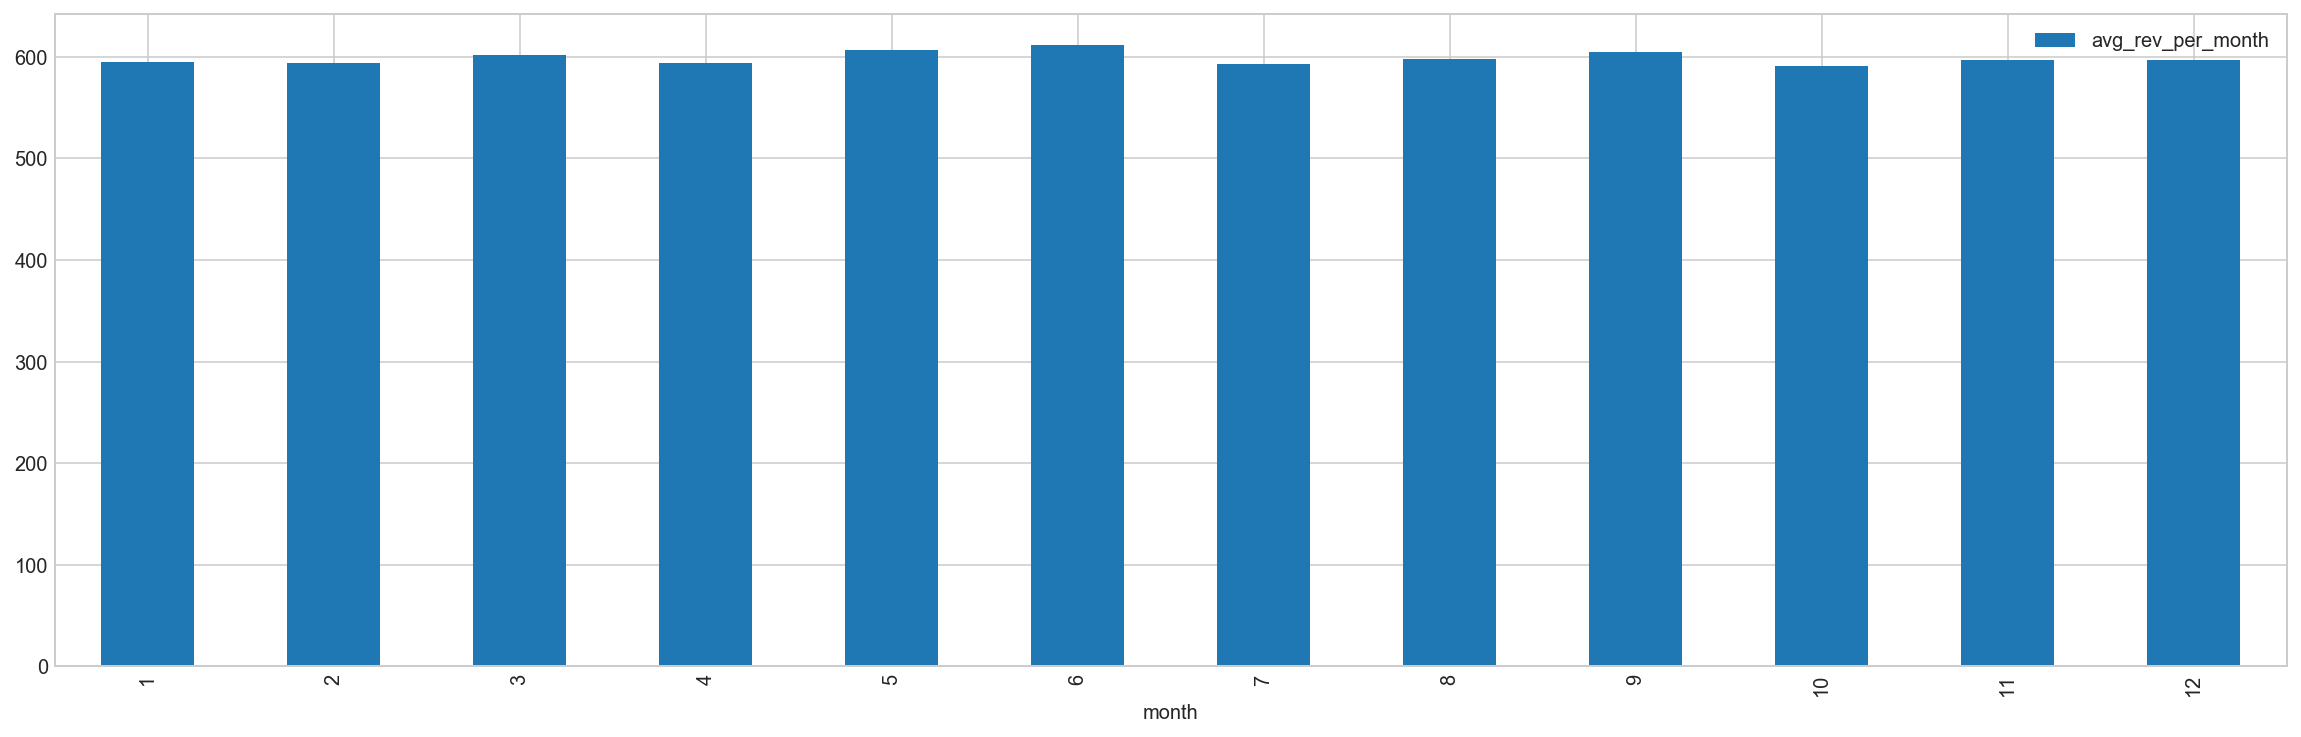

In [42]:
avg_rev_per_month.toPandas().plot.bar(x='month');

### 4.3.2 Get Total Revenue Per Month Per Year:

**SQL:**

In [43]:
spark.sql(strip_margin(
        """SELECT year(o.order_date) as order_year, month(o.order_date) as order_month, sum(oi.order_item_subtotal) tot_revenue 
          |FROM orders o JOIN order_items oi 
          |    ON o.order_id = oi.order_item_order_id
          |GROUP BY order_year, order_month 
          |ORDER BY order_year, order_month
        """)).show(truncate=False)

+----------+-----------+------------------+
|order_year|order_month|tot_revenue       |
+----------+-----------+------------------+
|2013      |7          |764782.2047252655 |
|2013      |8          |2828658.754573822 |
|2013      |9          |2934527.3265972137|
|2013      |10         |2624600.6605644226|
|2013      |11         |3168656.0921707153|
|2013      |12         |2932964.327445984 |
|2014      |1          |2924447.0670757294|
|2014      |2          |2778663.7149181366|
|2014      |3          |2862492.265932083 |
|2014      |4          |2807789.8547916412|
|2014      |5          |2753078.2738227844|
|2014      |6          |2703463.491306305 |
|2014      |7          |2238496.5645008087|
+----------+-----------+------------------+



**DF API:**

In [44]:
tot_rev_per_month_per_year = (orders_df.join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
     .select([F.year('order_date').alias('order_year'), F.month('order_date').alias('order_month'), 'order_item_subtotal'])
     .groupBy(['order_year', 'order_month'])
     .agg(F.sum('order_item_subtotal').alias('tot_revenue'))
     .orderBy(['order_year', 'order_month'])).cache()

In [45]:
tot_rev_per_month_per_year.show()

+----------+-----------+------------------+
|order_year|order_month|       tot_revenue|
+----------+-----------+------------------+
|      2013|          7| 764782.2047252655|
|      2013|          8| 2828658.754573822|
|      2013|          9|2934527.3265972137|
|      2013|         10|2624600.6605644226|
|      2013|         11|3168656.0921707153|
|      2013|         12| 2932964.327445984|
|      2014|          1|2924447.0670757294|
|      2014|          2|2778663.7149181366|
|      2014|          3| 2862492.265932083|
|      2014|          4|2807789.8547916412|
|      2014|          5|2753078.2738227844|
|      2014|          6| 2703463.491306305|
|      2014|          7|2238496.5645008087|
+----------+-----------+------------------+



In [46]:
pdf = tot_rev_per_month_per_year.toPandas()

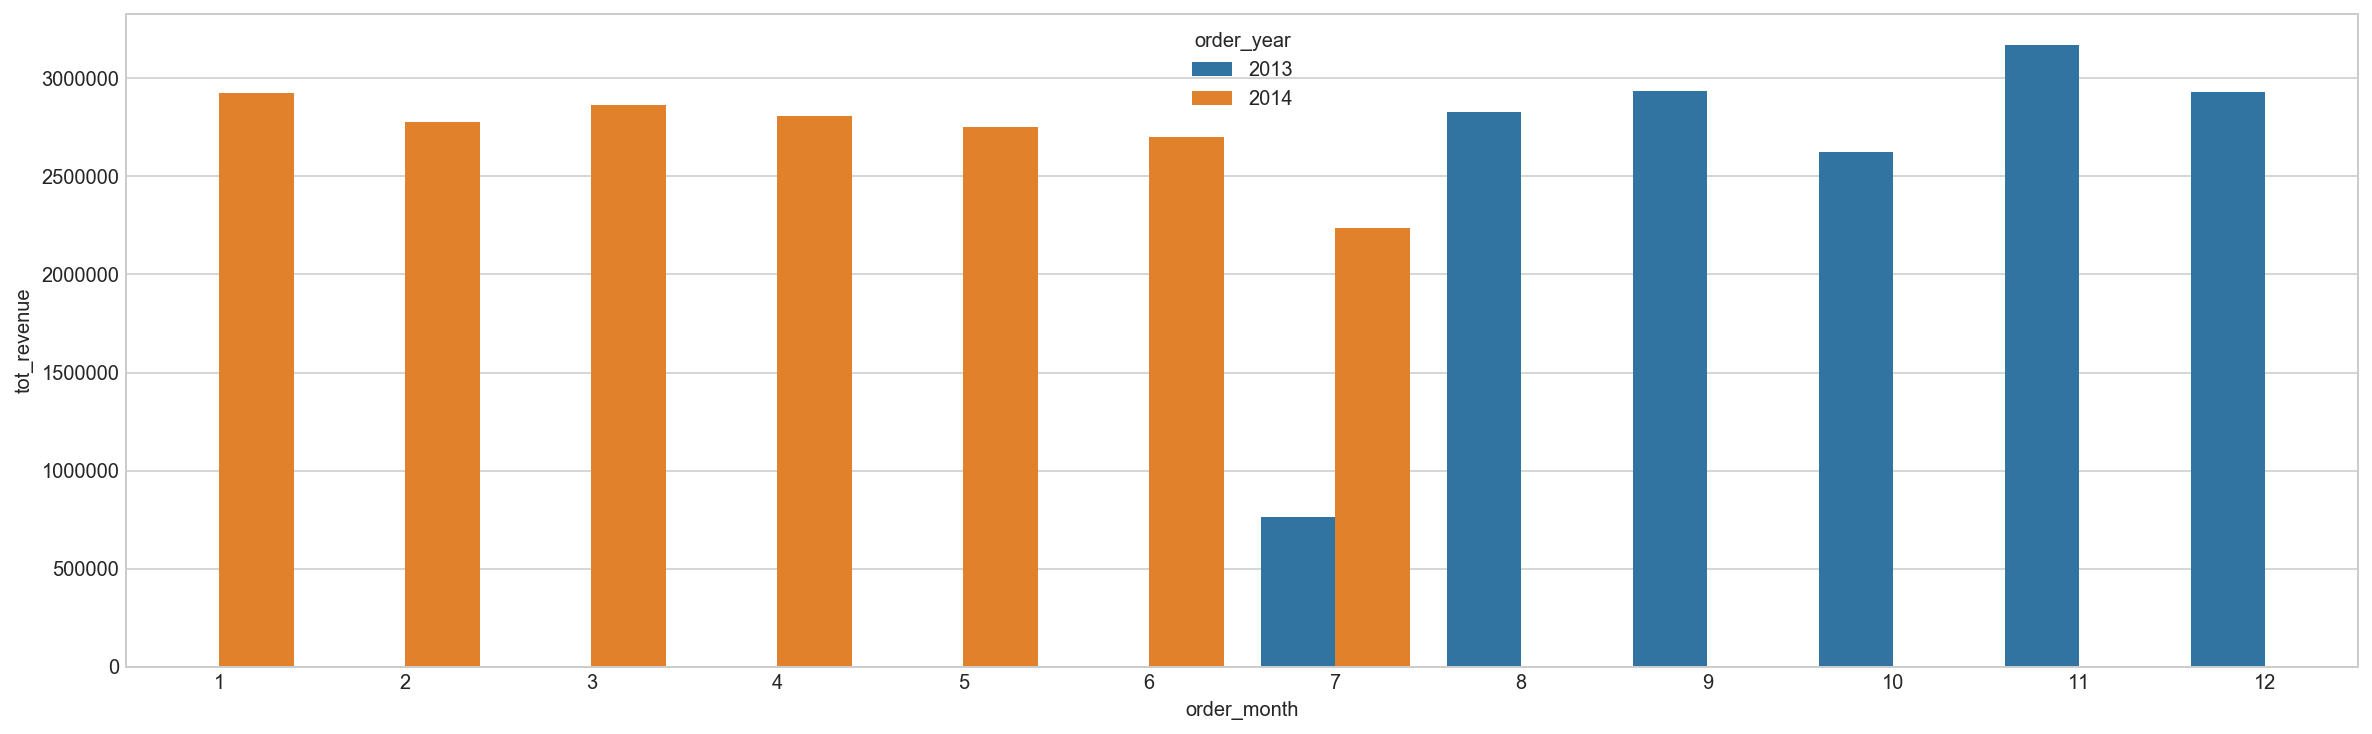

In [47]:
sns.barplot(x='order_month', y='tot_revenue', hue='order_year', data=pdf);

### 4.4 Top Performing Departments:

**SQL:**

In [48]:
spark.sql(strip_margin(
        """SELECT d.department_name, year(o.order_date) as order_year, sum(oi.order_item_subtotal) as tot_revenue
          |FROM orders o 
          |    INNER JOIN order_items oi 
          |        ON o.order_id = oi.order_item_order_id
          |    INNER JOIN products p
          |        ON oi.order_item_product_id = p.product_id
          |    INNER JOIN categories c
          |        ON c.category_id = p.product_category_id
          |    INNER JOIN departments d
          |        ON c.category_department_id = d.department_id
          |WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
          |GROUP BY d.department_name, order_year
          |ORDER BY d.department_name, order_year
        """)).show(truncate=False)

+---------------+----------+------------------+
|department_name|order_year|tot_revenue       |
+---------------+----------+------------------+
|Apparel        |2013      |3090985.6535224915|
|Apparel        |2014      |3917585.841217041 |
|Fan Shop       |2013      |7290831.879999161 |
|Fan Shop       |2014      |9095735.77280426  |
|Fitness        |2013      |119526.58082199097|
|Fitness        |2014      |150509.1409931183 |
|Footwear       |2013      |1711492.5186824799|
|Footwear       |2014      |2122339.649032593 |
|Golf           |2013      |1967396.959728241 |
|Golf           |2014      |2440585.2815055847|
|Outdoors       |2013      |420317.9507675171 |
|Outdoors       |2014      |532437.6709976196 |
+---------------+----------+------------------+



**DF API:**

In [49]:
df = (orders_df
      .filter((orders_df.order_status != 'CANCELED') & (orders_df.order_status != 'SUSPECTED_FRAUD'))
      .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id, how='inner')
      .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
      .join(categories_df, products_df.product_category_id == categories_df.category_id, how='inner')
      .join(departments_df, categories_df.category_department_id == departments_df.department_id, how='inner')
      .select('department_name', F.year(orders_df.order_date).alias('order_year'), 'order_item_subtotal')
      .groupBy([departments_df.department_name, 'order_year'])
      .agg(F.sum(order_items_df.order_item_subtotal).alias('tot_revenue'))
      .orderBy('department_name', 'order_year')
      .cache())

In [50]:
df.show()

+---------------+----------+------------------+
|department_name|order_year|       tot_revenue|
+---------------+----------+------------------+
|        Apparel|      2013|3090985.6535224915|
|        Apparel|      2014| 3917585.841217041|
|       Fan Shop|      2013| 7290831.879999161|
|       Fan Shop|      2014|  9095735.77280426|
|        Fitness|      2013|119526.58082199097|
|        Fitness|      2014| 150509.1409931183|
|       Footwear|      2013|1711492.5186824799|
|       Footwear|      2014| 2122339.649032593|
|           Golf|      2013| 1967396.959728241|
|           Golf|      2014|2440585.2815055847|
|       Outdoors|      2013| 420317.9507675171|
|       Outdoors|      2014| 532437.6709976196|
+---------------+----------+------------------+



In [51]:
pdf = df.toPandas()

In [52]:
pdf = pdf.pivot(index='department_name', columns='order_year', values='tot_revenue')

In [53]:
print(pdf)

order_year               2013          2014
department_name                            
Apparel          3.090986e+06  3.917586e+06
Fan Shop         7.290832e+06  9.095736e+06
Fitness          1.195266e+05  1.505091e+05
Footwear         1.711493e+06  2.122340e+06
Golf             1.967397e+06  2.440585e+06
Outdoors         4.203180e+05  5.324377e+05


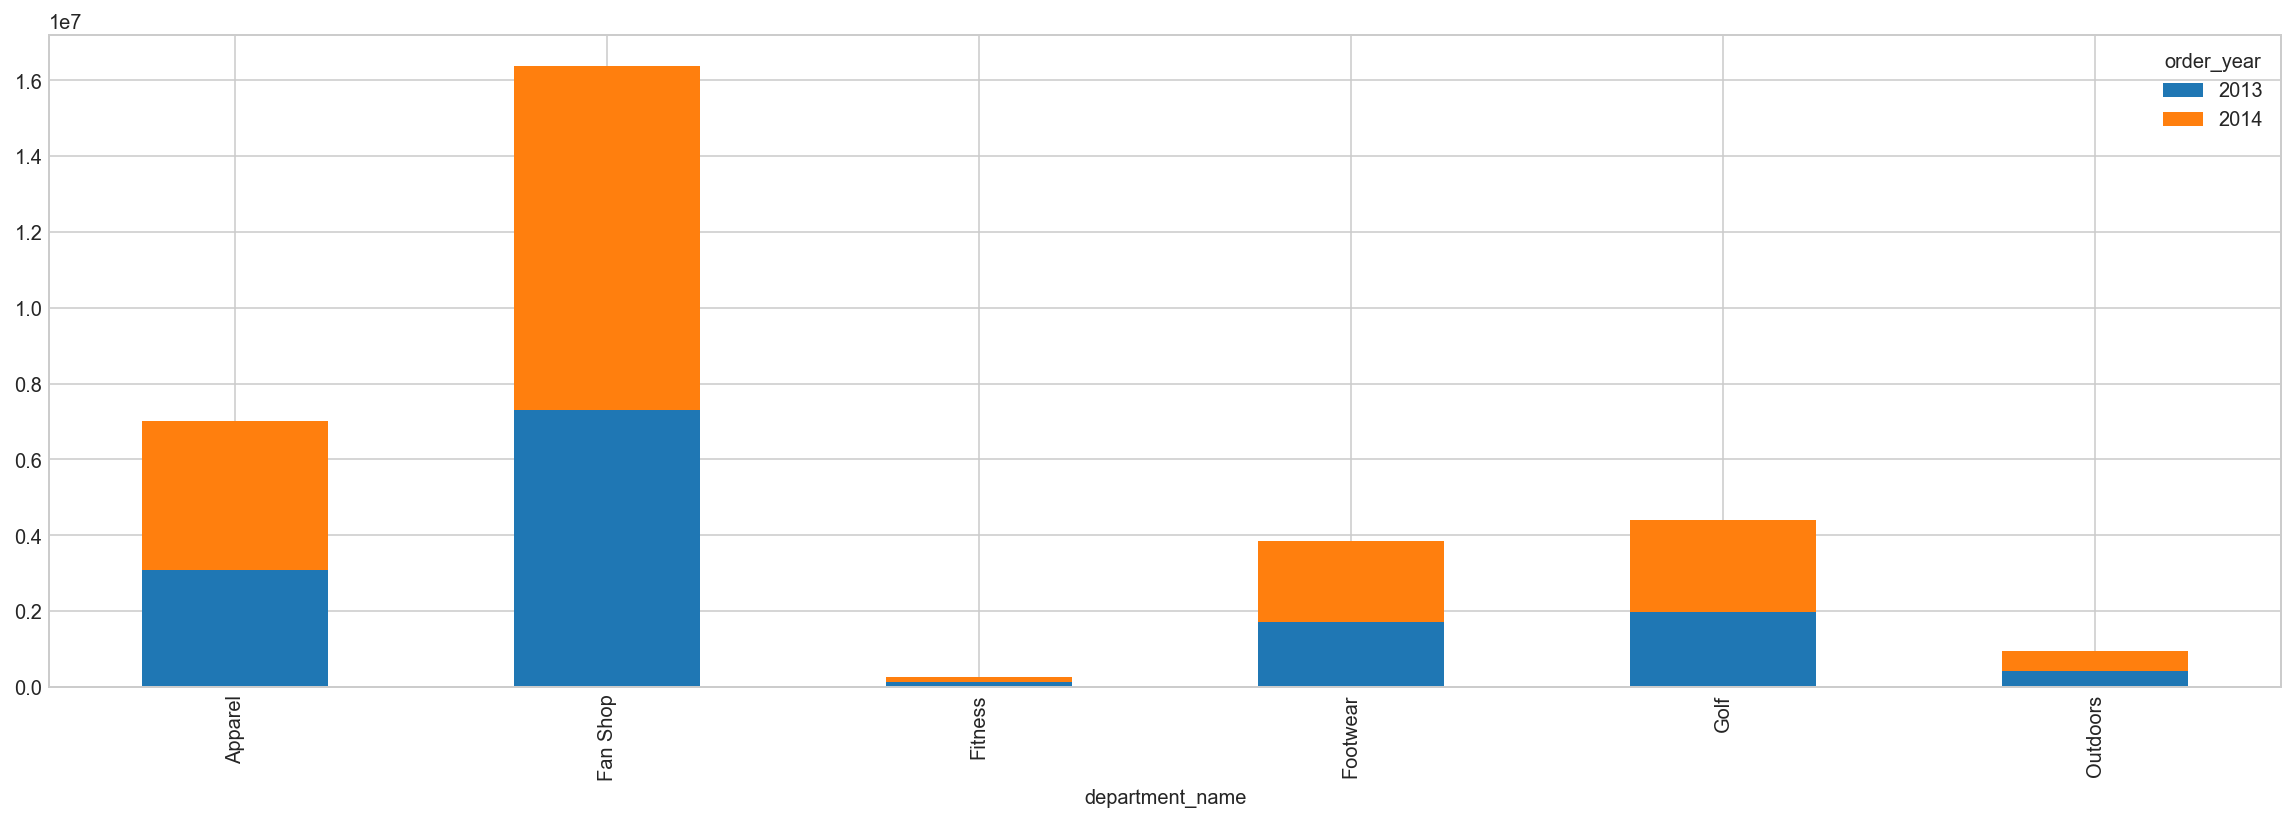

In [54]:
pdf.plot.bar(stacked=True);

### 4.5 Get Highest Priced Product:

**SQL:**

In [55]:
spark.sql(strip_margin(
        """SELECT p.* 
          |FROM products p
          |WHERE p.product_price = (SELECT max(q.product_price) FROM products q)
        """)).show()

+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+



**SQL Using rank() Window Function:**

In [56]:
spark.sql(strip_margin(
        """SELECT * 
          |FROM ( 
          |    SELECT *, 
          |         rank() OVER (ORDER BY product_price DESC) as rank
          |    FROM products) tmp
          |WHERE rank <= 1
        """)).show()

+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|rank|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|   1|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+



**DF API:**

In [57]:
(products_df
 .select('*')
 .filter(col('product_price') == products_df.select(F.max('product_price')).collect()[0][0])
 .show())

+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+



**DF API Using Window Function:**

In [58]:
windowSpec = Window.orderBy(products_df['product_price'].desc())

In [59]:
products_df.select('*', F.rank().over(windowSpec).alias('rank')).filter(col('rank') <= 1).show()

+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|product_id|product_category_id|       product_name|product_description|product_price|       product_image|rank|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+
|       208|                 10|SOLE E35 Elliptical|               null|      1999.99|http://images.acm...|   1|
+----------+-------------------+-------------------+-------------------+-------------+--------------------+----+



### 4.6 Get Highest Revenue Earning Products:

**SQL:**

In [60]:
spark.sql(strip_margin(
        """SELECT p.*, r.product_revenue
          |FROM products p, (SELECT oi.order_item_product_id, sum(CAST(oi.order_item_subtotal as float)) as product_revenue
          |                    FROM order_items oi 
          |                    GROUP BY order_item_product_id 
          |                    ORDER BY product_revenue DESC 
          |                    LIMIT 1) r
          |WHERE product_id = r.order_item_product_id
        """)).show()

+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|  product_revenue|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+
|      1004|                 45|Field & Stream Sp...|               null|       399.98|http://images.acm...|6929653.690338135|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+-----------------+



**SQL:**

In [61]:
# Top 10 revenue generating products (another way of doing similar thing as above)
spark.sql(strip_margin(
        """SELECT p.product_id, p.product_category_id, p.product_name, r.product_revenue
          |FROM products p INNER JOIN
          |                    (SELECT oi.order_item_product_id, round(sum(CAST(oi.order_item_subtotal as float)), 2) as product_revenue
          |                     FROM order_items oi INNER JOIN orders o 
          |                         ON oi.order_item_order_id = o.order_id
          |                     WHERE o.order_status <> 'CANCELED'
          |                     AND o.order_status <> 'SUSPECTED_FRAUD'
          |                     GROUP BY oi.order_item_product_id) r
          |ON p.product_id = r.order_item_product_id
          |ORDER BY r.product_revenue DESC
          |LIMIT 10
        """)).show(truncate=False)

+----------+-------------------+---------------------------------------------+---------------+
|product_id|product_category_id|product_name                                 |product_revenue|
+----------+-------------------+---------------------------------------------+---------------+
|1004      |45                 |Field & Stream Sportsman 16 Gun Fire Safe    |6637668.28     |
|365       |17                 |Perfect Fitness Perfect Rip Deck             |4233794.37     |
|957       |43                 |Diamondback Women's Serene Classic Comfort Bi|3946837.0      |
|191       |9                  |Nike Men's Free 5.0+ Running Shoe            |3507549.21     |
|502       |24                 |Nike Men's Dri-FIT Victory Golf Polo         |3011600.0      |
|1073      |48                 |Pelican Sunstream 100 Kayak                  |2967851.68     |
|1014      |46                 |O'Brien Men's Neoprene Life Vest             |2765543.31     |
|403       |18                 |Nike Men's CJ Elit

**DF API:**

In [62]:
# 1. Get the sum of revenue of all the products grouped by order_item_product_id from order_items table
# 2. Sort the result in descending order of their revenues
# 3. Take only the first one from the sorted order using the limit() function
# 4. Join with the prorcuts column to get the product details
(order_items_df.select(['order_item_product_id', 'order_item_subtotal'])
     .groupBy('order_item_product_id')
     .agg(F.sum('order_item_subtotal').alias('product_revenue'))
     .orderBy('product_revenue', ascending=False)
     .limit(1)
     .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
     .select('product_id', 'product_category_id', 'product_name', 'product_revenue')
     .show())

+----------+-------------------+--------------------+-----------------+
|product_id|product_category_id|        product_name|  product_revenue|
+----------+-------------------+--------------------+-----------------+
|      1004|                 45|Field & Stream Sp...|6929653.690338135|
+----------+-------------------+--------------------+-----------------+



### 4.7 Top 5 Highest Revenue Earning Products Per Month Per Year:

**SQL:**

In [63]:
# Map from month number to actual month string
monthmap = {1:"Jan", 2:"Feb", 3:"Mar",  4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

In [64]:
# in order to use an udf with sql it needs to be registerd to sqlContext
sqlContext.udf.register("udfmonTomonth", lambda m: monthmap[m], StringType())

<function __main__.<lambda>>

In [65]:
df = spark.sql(strip_margin(
        """SELECT q.* 
          |FROM (
          |     SELECT r.*, DENSE_RANK() OVER (PARTITION by order_year, order_month ORDER BY product_revenue DESC) as dense_rank
          |     FROM (
          |          SELECT YEAR(o.order_date) as order_year, udfmonTomonth(MONTH(o.order_date)) as order_month, p.product_name, ROUND(SUM(CAST(oi.order_item_subtotal as float)), 2) as product_revenue
          |          FROM order_items oi 
          |              INNER JOIN orders o 
          |                  ON oi.order_item_order_id = o.order_id
          |              INNER JOIN products p
          |                  ON oi.order_item_product_id = p.product_id
          |              WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD'
          |              GROUP BY order_year, order_month, p.product_name ) r ) q
          |WHERE q.dense_rank <= 5
          |ORDER BY q.order_year, q.order_month, q.dense_rank
        """)).cache()

In [66]:
df.show(truncate=False)

+----------+-----------+---------------------------------------------+---------------+----------+
|order_year|order_month|product_name                                 |product_revenue|dense_rank|
+----------+-----------+---------------------------------------------+---------------+----------+
|2013      |Aug        |Field & Stream Sportsman 16 Gun Fire Safe    |540772.97      |1         |
|2013      |Aug        |Perfect Fitness Perfect Rip Deck             |349861.69      |2         |
|2013      |Aug        |Diamondback Women's Serene Classic Comfort Bi|319778.69      |3         |
|2013      |Aug        |Nike Men's Free 5.0+ Running Shoe            |279172.08      |4         |
|2013      |Aug        |Nike Men's Dri-FIT Victory Golf Polo         |247700.0       |5         |
|2013      |Dec        |Field & Stream Sportsman 16 Gun Fire Safe    |595570.24      |1         |
|2013      |Dec        |Perfect Fitness Perfect Rip Deck             |342842.86      |2         |
|2013      |Dec     

In [67]:
pdf = df.toPandas()

**For 2013:**

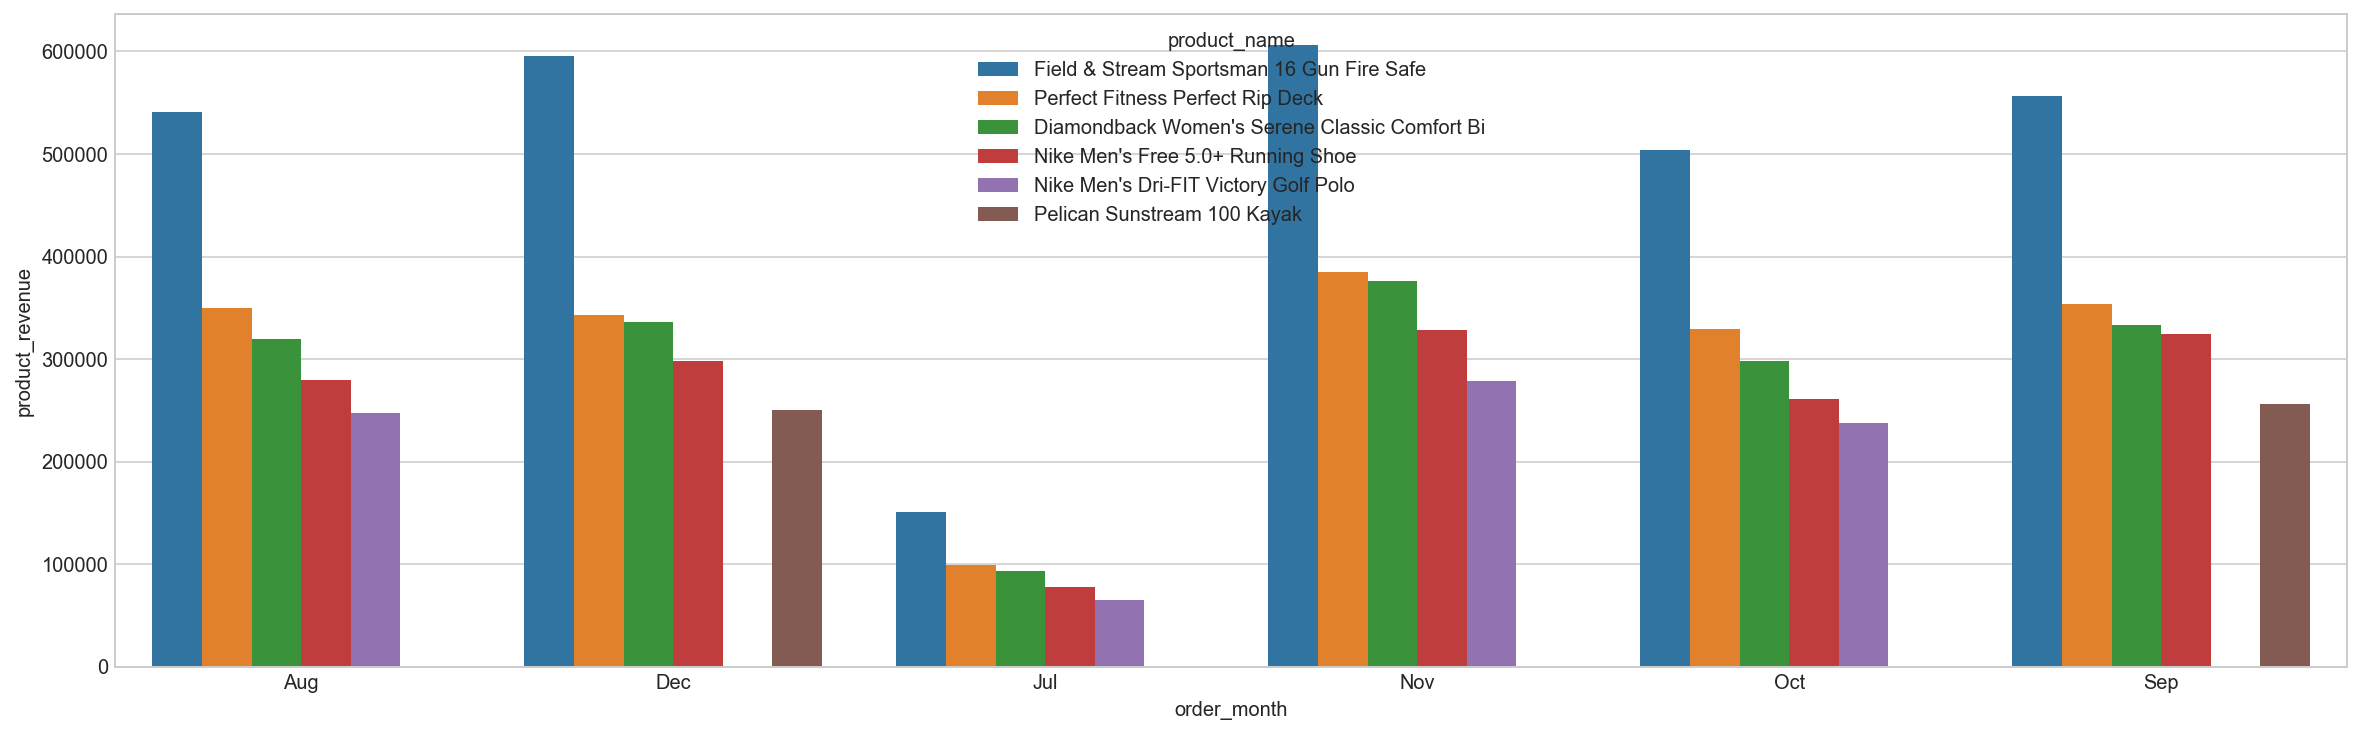

In [68]:
sns.barplot(x="order_month", y="product_revenue", hue="product_name", data=pdf[pdf['order_year'] == 2013]);

**For 2014:**

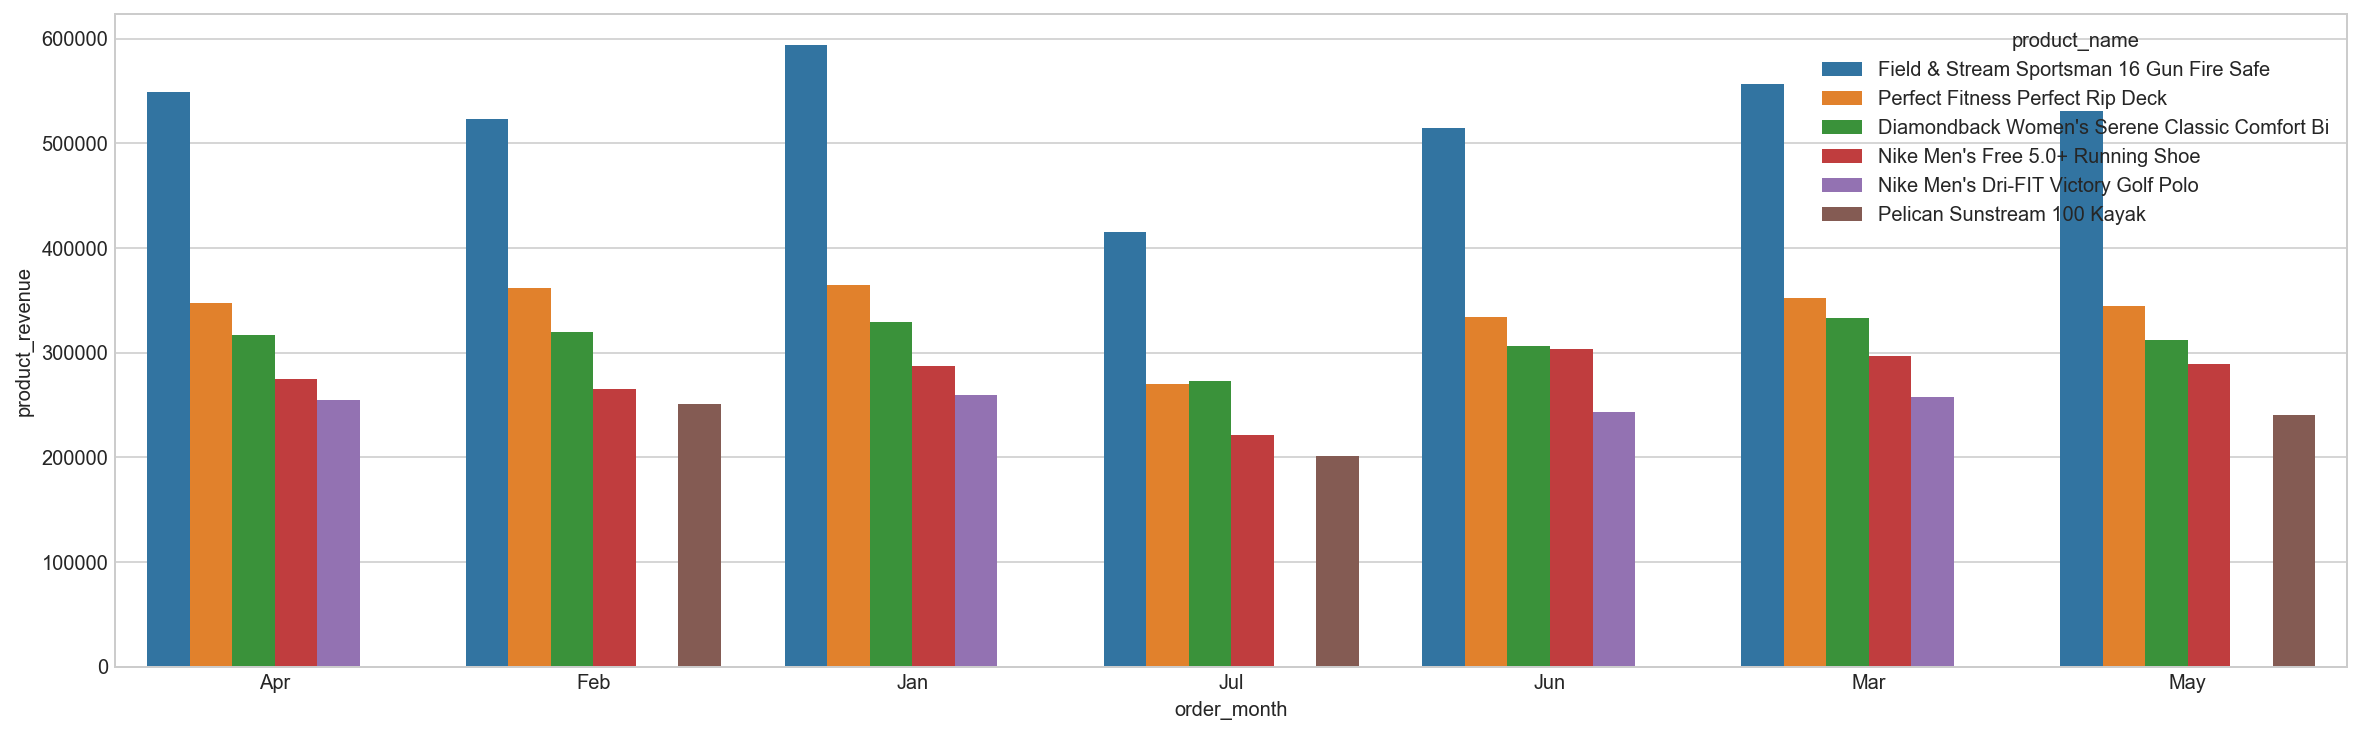

In [69]:
sns.barplot(x="order_month", y="product_revenue", hue="product_name", data=pdf[pdf['order_year'] == 2014]);

**DF API:**

In [70]:
# Define a udf
udfmonTomonth = udf(lambda m: monthmap[m], StringType())

In [71]:
rev_per_month_per_year_per_product = (orders_df
                         .select(F.year('order_date').alias('order_year'), udfmonTomonth(F.month('order_date')).alias('order_month'), 'order_id', 'order_status')
                         .where((col('order_status') != 'CANCELED') & (col('order_status') != 'SUSPECTED_FRAUD'))
                         .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id, how='inner')
                         .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
                         .select(['order_year', 'order_month', 'product_name', 'order_item_subtotal'])
                         .groupBy(['order_year', 'order_month', 'product_name'])
                         .agg(F.round(F.sum('order_item_subtotal'), 2).alias('product_revenue'))).cache()

In [72]:
rev_per_month_per_year_per_product.show(5, truncate=False)

+----------+-----------+---------------------------------------------+---------------+
|order_year|order_month|product_name                                 |product_revenue|
+----------+-----------+---------------------------------------------+---------------+
|2013      |Nov        |Under Armour Women's Micro G Skulpt Running S|3792.93        |
|2013      |Oct        |Polar Loop Activity Tracker                  |329.85         |
|2014      |Jan        |Bushnell Pro X7 Jolt Slope Rangefinder       |599.99         |
|2013      |Aug        |Hirzl Men's Hybrid Golf Glove                |1064.29        |
|2014      |Feb        |Titleist Small Wheeled Travel Cover          |249.99         |
+----------+-----------+---------------------------------------------+---------------+
only showing top 5 rows



In [73]:
windowSpec = Window.partitionBy([rev_per_month_per_year_per_product.order_year, rev_per_month_per_year_per_product.order_month]).orderBy(rev_per_month_per_year_per_product['product_revenue'].desc())

In [74]:
top_prod_per_month_per_year_by_rev = (rev_per_month_per_year_per_product
                           .select('*', F.dense_rank().over(windowSpec).alias('dense_rank'))
                           .filter(col('dense_rank') <= 5)
                           .orderBy(['order_year', 'order_month', 'dense_rank'])).cache()

In [75]:
top_prod_per_month_per_year_by_rev.show(truncate=False)

+----------+-----------+---------------------------------------------+---------------+----------+
|order_year|order_month|product_name                                 |product_revenue|dense_rank|
+----------+-----------+---------------------------------------------+---------------+----------+
|2013      |Aug        |Field & Stream Sportsman 16 Gun Fire Safe    |540772.97      |1         |
|2013      |Aug        |Perfect Fitness Perfect Rip Deck             |349861.69      |2         |
|2013      |Aug        |Diamondback Women's Serene Classic Comfort Bi|319778.69      |3         |
|2013      |Aug        |Nike Men's Free 5.0+ Running Shoe            |279172.08      |4         |
|2013      |Aug        |Nike Men's Dri-FIT Victory Golf Polo         |247700.0       |5         |
|2013      |Dec        |Field & Stream Sportsman 16 Gun Fire Safe    |595570.24      |1         |
|2013      |Dec        |Perfect Fitness Perfect Rip Deck             |342842.86      |2         |
|2013      |Dec     

### 4.8 Get the most popular Categories:

**SQL:**

In [76]:
spark.sql(strip_margin(
        """SELECT c.category_name, count(order_item_quantity) as order_count 
          |FROM order_items oi 
          |INNER JOIN products p on oi.order_item_product_id = p.product_id 
          |INNER JOIN categories c on c.category_id = p.product_category_id 
          |GROUP BY c.category_name 
          |ORDER BY order_count DESC 
          |LIMIT 10 
        """)).show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      24551|
|      Men's Footwear|      22246|
|     Women's Apparel|      21035|
|Indoor/Outdoor Games|      19298|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|    Cardio Equipment|      12487|
|       Shop By Sport|      10984|
|         Electronics|       3156|
+--------------------+-----------+



**DF API:**

In [77]:
pop_cat = (order_items_df
 .join(products_df, order_items_df.order_item_product_id == products_df.product_id, how='inner')
 .join(categories_df, categories_df.category_id == products_df.product_category_id, how='inner')
 .groupBy('category_name')
 .agg(F.sum('order_item_quantity').alias('order_count'))
 .orderBy('order_count', ascending=False)
 .limit(10)).cache()

In [78]:
pop_cat.show()

+--------------------+-----------+
|       category_name|order_count|
+--------------------+-----------+
|              Cleats|      73734|
|     Women's Apparel|      62956|
|Indoor/Outdoor Games|      57803|
|    Cardio Equipment|      37587|
|       Shop By Sport|      32726|
|      Men's Footwear|      22246|
|             Fishing|      17325|
|        Water Sports|      15540|
|    Camping & Hiking|      13729|
|         Electronics|       9436|
+--------------------+-----------+



In [79]:
pdf = pop_cat.toPandas()

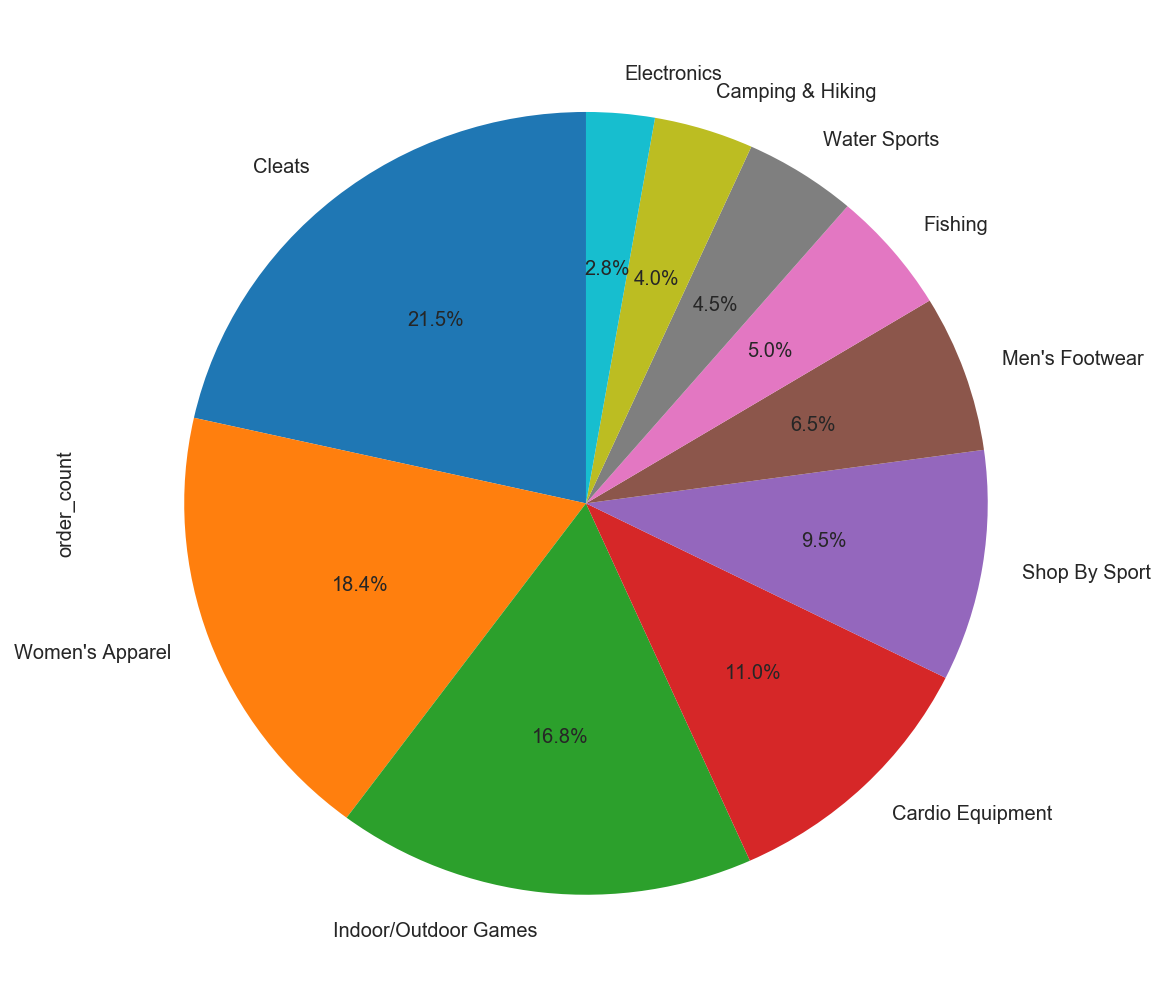

In [80]:
pdf.plot(kind='pie', y = 'order_count', autopct='%1.1f%%', startangle=90, labels=pdf['category_name'], legend=False, figsize=(9, 9));

### 4.9 Get Number of Orders By Status:

**SQL:**

In [81]:
spark.sql(strip_margin(
        """SELECT order_status, count(1) as total
          |FROM orders o
          |GROUP BY o.order_status
        """)).show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



**DF API:**

In [82]:
df = orders_df.groupBy(orders_df.order_status).count().withColumnRenamed('count', 'total').cache()

In [83]:
df.show()

+---------------+-----+
|   order_status|total|
+---------------+-----+
|PENDING_PAYMENT|15030|
|       COMPLETE|22899|
|        ON_HOLD| 3798|
| PAYMENT_REVIEW|  729|
|     PROCESSING| 8275|
|         CLOSED| 7556|
|SUSPECTED_FRAUD| 1558|
|        PENDING| 7610|
|       CANCELED| 1428|
+---------------+-----+



In [84]:
pdf = df.toPandas()

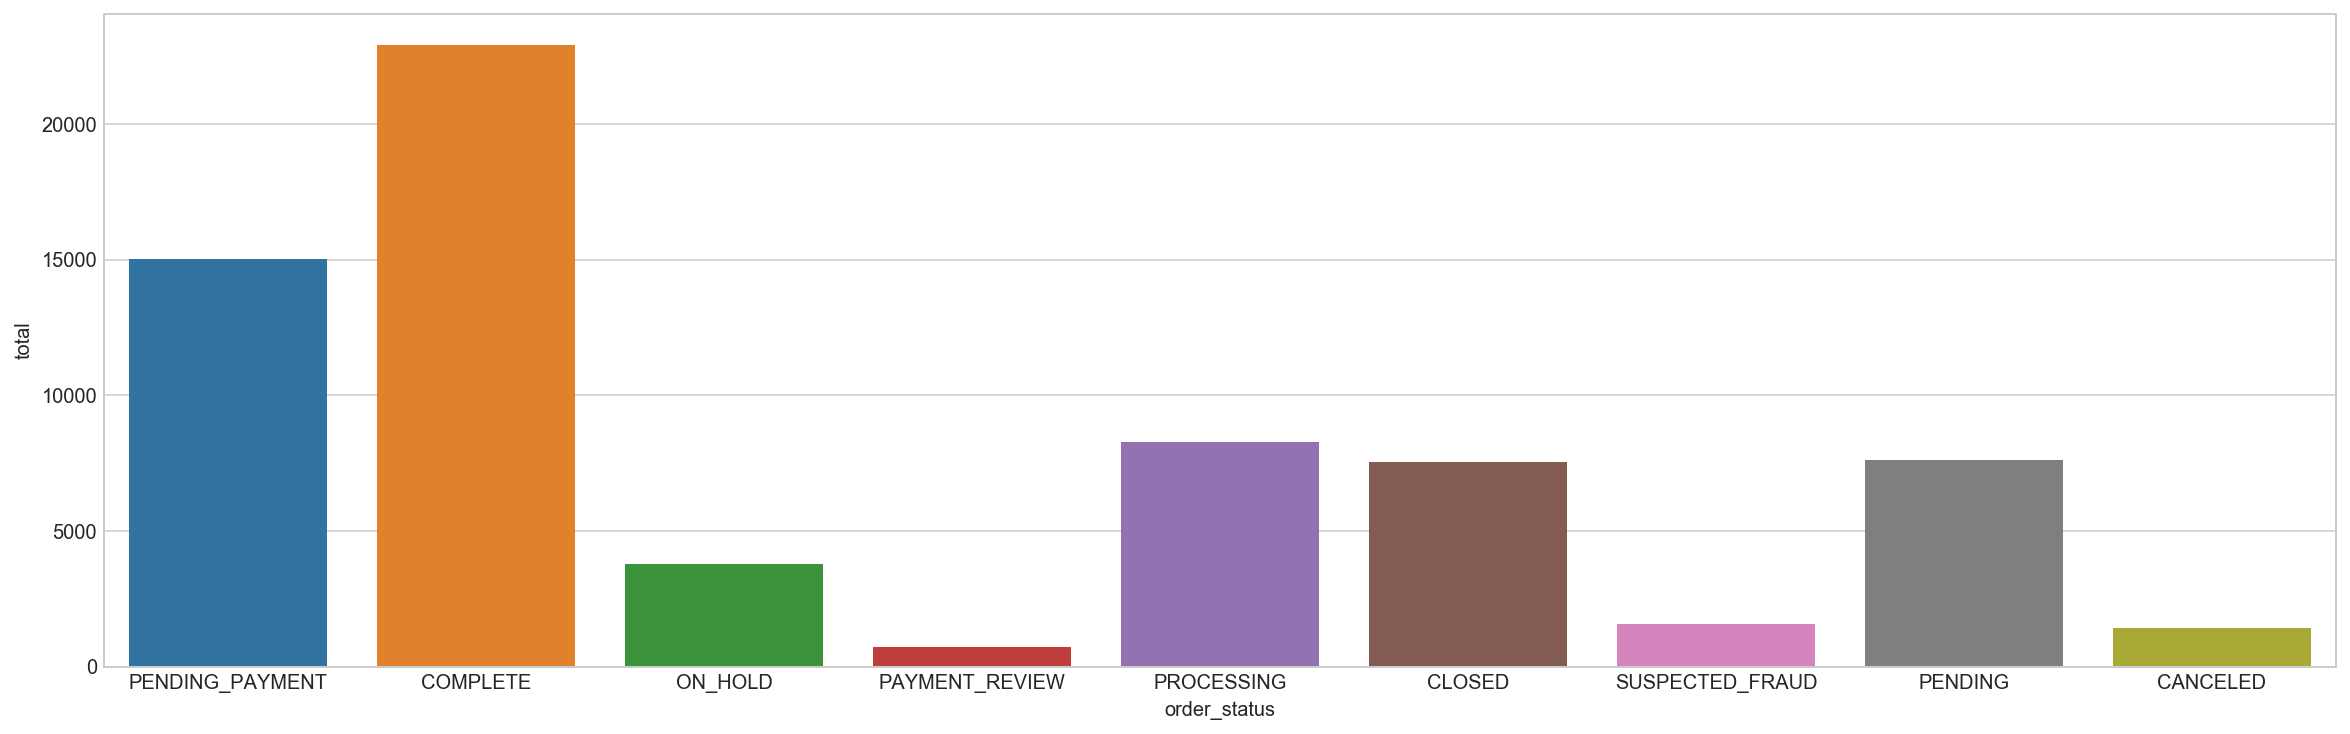

In [85]:
sns.barplot(x='order_status', y='total', data=pdf);

### 4.10 Get Number of Orders By Order Date and Order Status:

**SQL:**

In [86]:
spark.sql(strip_margin(
        """SELECT order_date, order_status, count(1) as total
          |FROM orders o
          |GROUP BY order_date, o.order_status
        """)).show(truncate=False)

+---------------------+---------------+-----+
|order_date           |order_status   |total|
+---------------------+---------------+-----+
|2013-08-16 00:00:00.0|COMPLETE       |43   |
|2013-08-30 00:00:00.0|CLOSED         |17   |
|2013-09-10 00:00:00.0|COMPLETE       |80   |
|2013-10-05 00:00:00.0|SUSPECTED_FRAUD|4    |
|2013-12-02 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-09 00:00:00.0|ON_HOLD        |9    |
|2013-12-20 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-23 00:00:00.0|PAYMENT_REVIEW |2    |
|2014-01-02 00:00:00.0|CLOSED         |15   |
|2014-02-11 00:00:00.0|CANCELED       |3    |
|2014-02-14 00:00:00.0|ON_HOLD        |11   |
|2014-02-21 00:00:00.0|PROCESSING     |25   |
|2014-05-13 00:00:00.0|SUSPECTED_FRAUD|3    |
|2014-06-27 00:00:00.0|PENDING        |26   |
|2014-07-16 00:00:00.0|ON_HOLD        |3    |
|2013-08-16 00:00:00.0|PENDING_PAYMENT|30   |
|2013-08-29 00:00:00.0|PROCESSING     |31   |
|2013-09-10 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-09-25 00:00:00.0|CLOSED     

**DF API:**

In [87]:
(orders_df
 .groupBy([orders_df.order_date, orders_df.order_status])
 .count().withColumnRenamed('count', 'total')
 .show(truncate=False))

+---------------------+---------------+-----+
|order_date           |order_status   |total|
+---------------------+---------------+-----+
|2013-08-16 00:00:00.0|COMPLETE       |43   |
|2013-08-30 00:00:00.0|CLOSED         |17   |
|2013-09-10 00:00:00.0|COMPLETE       |80   |
|2013-10-05 00:00:00.0|SUSPECTED_FRAUD|4    |
|2013-12-02 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-09 00:00:00.0|ON_HOLD        |9    |
|2013-12-20 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-12-23 00:00:00.0|PAYMENT_REVIEW |2    |
|2014-01-02 00:00:00.0|CLOSED         |15   |
|2014-02-11 00:00:00.0|CANCELED       |3    |
|2014-02-14 00:00:00.0|ON_HOLD        |11   |
|2014-02-21 00:00:00.0|PROCESSING     |25   |
|2014-05-13 00:00:00.0|SUSPECTED_FRAUD|3    |
|2014-06-27 00:00:00.0|PENDING        |26   |
|2014-07-16 00:00:00.0|ON_HOLD        |3    |
|2013-08-16 00:00:00.0|PENDING_PAYMENT|30   |
|2013-08-29 00:00:00.0|PROCESSING     |31   |
|2013-09-10 00:00:00.0|SUSPECTED_FRAUD|3    |
|2013-09-25 00:00:00.0|CLOSED     

### 4.11 Get all CANCELED orders with amount greater than \$1000:

**SQL:**

In [88]:
spark.sql(strip_margin(
    """SELECT q.* 
      |FROM (SELECT o.order_id, o.order_date, o.order_customer_id, o.order_status, sum(oi.order_item_subtotal) as order_total 
      |      FROM orders o INNER JOIN order_items oi 
      |          ON o.order_id = oi.order_item_order_id 
      |      WHERE o.order_status = 'CANCELED' 
      |      GROUP BY o.order_id, o.order_date, o.order_customer_id, o.order_status) q 
      |WHERE q.order_total >= 1000 
      |ORDER BY q.order_id
    """)).show(truncate=False)

+--------+---------------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_status|order_total       |
+--------+---------------------+-----------------+------------+------------------+
|753     |2013-07-29 00:00:00.0|5094             |CANCELED    |1129.75           |
|2012    |2013-08-04 00:00:00.0|5165             |CANCELED    |1499.8600311279297|
|2144    |2013-08-05 00:00:00.0|7932             |CANCELED    |1099.900032043457 |
|2189    |2013-08-06 00:00:00.0|6829             |CANCELED    |1029.9400253295898|
|2271    |2013-08-06 00:00:00.0|7603             |CANCELED    |1229.9300231933594|
|2754    |2013-08-09 00:00:00.0|8946             |CANCELED    |1109.9500274658203|
|3551    |2013-08-14 00:00:00.0|5363             |CANCELED    |1299.8700408935547|
|4354    |2013-08-20 00:00:00.0|7268             |CANCELED    |1047.9000244140625|
|4801    |2013-08-23 00:00:00.0|11630            |CANCELED    |1016.9500217437744|
|533

**DF API:**

In [89]:
cancelled_orders = (orders_df
                 .filter(col('order_status') == 'CANCELED')
                 .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
                 .groupBy(orders_df.order_id, orders_df.order_date, orders_df.order_customer_id, orders_df.order_status)
                 .agg(F.sum('order_item_subtotal').alias('order_total'))
                 .filter(col('order_total') >= 1000)
                 .orderBy('order_id').cache())

In [90]:
cancelled_orders.show(truncate=False)

+--------+---------------------+-----------------+------------+------------------+
|order_id|order_date           |order_customer_id|order_status|order_total       |
+--------+---------------------+-----------------+------------+------------------+
|753     |2013-07-29 00:00:00.0|5094             |CANCELED    |1129.75           |
|2012    |2013-08-04 00:00:00.0|5165             |CANCELED    |1499.8600311279297|
|2144    |2013-08-05 00:00:00.0|7932             |CANCELED    |1099.900032043457 |
|2189    |2013-08-06 00:00:00.0|6829             |CANCELED    |1029.9400253295898|
|2271    |2013-08-06 00:00:00.0|7603             |CANCELED    |1229.9300231933594|
|2754    |2013-08-09 00:00:00.0|8946             |CANCELED    |1109.9500274658203|
|3551    |2013-08-14 00:00:00.0|5363             |CANCELED    |1299.8700408935547|
|4354    |2013-08-20 00:00:00.0|7268             |CANCELED    |1047.9000244140625|
|4801    |2013-08-23 00:00:00.0|11630            |CANCELED    |1016.9500217437744|
|533

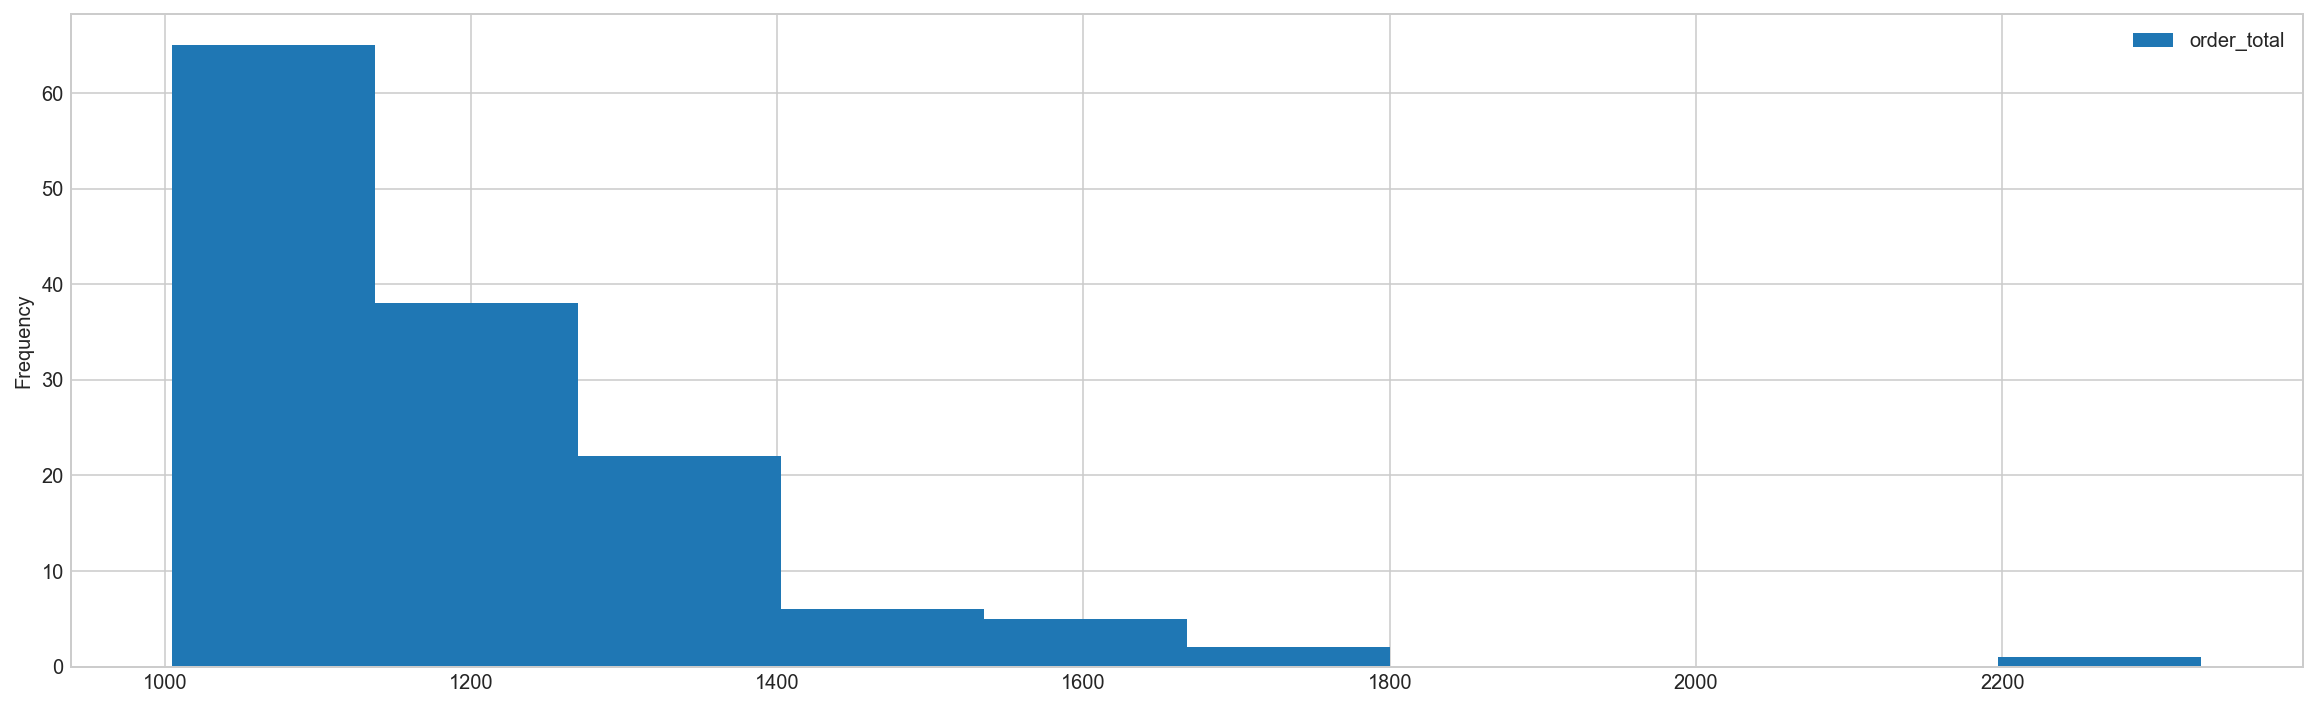

In [91]:
cancelled_orders.toPandas().plot.hist(y='order_total');

### 4.12 Sort Products by Category and Price:

**SQL:**

In [92]:
spark.sql(strip_margin(
        """SELECT p.product_id, p.product_category_id, p.product_name, p.product_price
          |FROM products p
          |ORDER BY p.product_category_id ASC, p.product_price DESC
        """)).show(truncate=False)

+----------+-------------------+---------------------------------------------+-------------+
|product_id|product_category_id|product_name                                 |product_price|
+----------+-------------------+---------------------------------------------+-------------+
|16        |2                  |Riddell Youth 360 Custom Football Helmet     |299.99       |
|11        |2                  |Fitness Gear 300 lb Olympic Weight Set       |209.99       |
|5         |2                  |Riddell Youth Revolution Speed Custom Footbal|199.99       |
|14        |2                  |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99       |
|12        |2                  |Under Armour Men's Highlight MC Alter Ego Fla|139.99       |
|23        |2                  |Under Armour Men's Highlight MC Alter Ego Hul|139.99       |
|6         |2                  |Jordan Men's VI Retro TD Football Cleat      |134.99       |
|20        |2                  |Under Armour Men's Highlight MC Footba

**DF API:**

In [93]:
(products_df
 .select(['product_id', 'product_category_id', 'product_name', 'product_price'])
 .orderBy(['product_category_id', 'product_price'], ascending=[1,0])
 .show(truncate=False))

+----------+-------------------+---------------------------------------------+-------------+
|product_id|product_category_id|product_name                                 |product_price|
+----------+-------------------+---------------------------------------------+-------------+
|16        |2                  |Riddell Youth 360 Custom Football Helmet     |299.99       |
|11        |2                  |Fitness Gear 300 lb Olympic Weight Set       |209.99       |
|5         |2                  |Riddell Youth Revolution Speed Custom Footbal|199.99       |
|14        |2                  |Quik Shade Summit SX170 10 FT. x 10 FT. Canop|199.99       |
|12        |2                  |Under Armour Men's Highlight MC Alter Ego Fla|139.99       |
|23        |2                  |Under Armour Men's Highlight MC Alter Ego Hul|139.99       |
|6         |2                  |Jordan Men's VI Retro TD Football Cleat      |134.99       |
|20        |2                  |Under Armour Men's Highlight MC Footba

### 4.13 Sort Products by Price within Each Category:

**SQL:**

In [94]:
spark.sql(strip_margin(
        """SELECT p.product_id, p.product_category_id, p.product_name, p.product_price
          |FROM products p 
          |DISTRIBUTE BY p.product_category_id 
          |SORT BY p.product_price DESC
        """)).sample(withReplacement=False, fraction=0.1, seed=23).show(truncate=False)

+----------+-------------------+----------------------------------------------+-------------+
|product_id|product_category_id|product_name                                  |product_price|
+----------+-------------------+----------------------------------------------+-------------+
|681       |31                 |Boccieri Golf EL C2-M Counterbalance Putter   |119.99       |
|1192      |53                 |Nike Men's Kobe IX Elite Low Basketball Shoe  |199.99       |
|747       |34                 |Ogio City Spiked Golf Shoes                   |149.99       |
|758       |34                 |TRUE linkswear Vegas Golf Shoes               |99.99        |
|595       |27                 |TYR Girls' Phoenix Maxfit Back Swimsuit       |75.99        |
|549       |26                 |Lotto Men's Zhero Gravity V 700 TF Soccer Cle |59.99        |
|551       |26                 |Lotto Men's Zhero Gravity V 700 TF Soccer Cle |59.99        |
|572       |26                 |TYR Boys' Team Digi Jammer  

In [95]:
(products_df
 .repartition('product_category_id')
 .sortWithinPartitions('product_price', ascending=0)
 .sample(withReplacement=False, fraction=0.1, seed=23)
 .select(['product_id', 'product_category_id', 'product_name', 'product_price'])
 .show(truncate=False))

+----------+-------------------+----------------------------------------------+-------------+
|product_id|product_category_id|product_name                                  |product_price|
+----------+-------------------+----------------------------------------------+-------------+
|681       |31                 |Boccieri Golf EL C2-M Counterbalance Putter   |119.99       |
|1192      |53                 |Nike Men's Kobe IX Elite Low Basketball Shoe  |199.99       |
|747       |34                 |Ogio City Spiked Golf Shoes                   |149.99       |
|758       |34                 |TRUE linkswear Vegas Golf Shoes               |99.99        |
|595       |27                 |TYR Girls' Phoenix Maxfit Back Swimsuit       |75.99        |
|549       |26                 |Lotto Men's Zhero Gravity V 700 TF Soccer Cle |59.99        |
|551       |26                 |Lotto Men's Zhero Gravity V 700 TF Soccer Cle |59.99        |
|572       |26                 |TYR Boys' Team Digi Jammer  

### 4.14 Get the topmost 5 products overall sorted by Price Highest to Lowest:
**sortN: get top 5 products by price overall; globalSorting**

**SQL:**

In [96]:
spark.sql(strip_margin(
        """SELECT product_id, product_category_id, product_name, product_price
          |FROM products
          |ORDER BY product_price DESC
          |LIMIT 5
        """)).show(truncate=False)

+----------+-------------------+------------------------------------------------+-------------+
|product_id|product_category_id|product_name                                    |product_price|
+----------+-------------------+------------------------------------------------+-------------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99      |
|66        |4                  |SOLE F85 Treadmill                              |1799.99      |
|199       |10                 |SOLE F85 Treadmill                              |1799.99      |
|496       |22                 |SOLE F85 Treadmill                              |1799.99      |
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99      |
+----------+-------------------+------------------------------------------------+-------------+



**DF API:**

In [97]:
(products_df
    .select('product_id', 'product_category_id', 'product_name', 'product_price')
     .orderBy('product_price', ascending=0)
     .limit(5)
     .show(truncate=False))

+----------+-------------------+------------------------------------------------+-------------+
|product_id|product_category_id|product_name                                    |product_price|
+----------+-------------------+------------------------------------------------+-------------+
|208       |10                 |SOLE E35 Elliptical                             |1999.99      |
|66        |4                  |SOLE F85 Treadmill                              |1799.99      |
|199       |10                 |SOLE F85 Treadmill                              |1799.99      |
|496       |22                 |SOLE F85 Treadmill                              |1799.99      |
|1048      |47                 |"Spalding Beast 60"" Glass Portable Basketball "|1099.99      |
+----------+-------------------+------------------------------------------------+-------------+



### 4.15 Get the topmost 5 products in each category where the products are sorted by Price Highest to Lowest:
**sort: sortingByKey, sort() by price per category**

**SQL:**

In [98]:
spark.sql(strip_margin(
        """SELECT product_category_id, product_id, product_name, product_price, row_num
          |FROM ( 
          |     SELECT q.*, row_number() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price) as row_num 
          |     FROM products q)
          |WHERE row_num <= 5 
          |ORDER BY product_category_id, row_num
          |      
        """)).show(truncate=False)

+-------------------+----------+----------------------------------------------+-------------+-------+
|product_category_id|product_id|product_name                                  |product_price|row_num|
+-------------------+----------+----------------------------------------------+-------------+-------+
|2                  |18        |Reebok Men's Full Zip Training Jacket         |29.97        |1      |
|2                  |22        |Kijaro Dual Lock Chair                        |29.99        |2      |
|2                  |9         |Nike Adult Vapor Jet 3.0 Receiver Gloves      |50.0         |3      |
|2                  |21        |Under Armour Kids' Highlight RM Football Clea |54.99        |4      |
|2                  |1         |Quest Q64 10 FT. x 10 FT. Slant Leg Instant U |59.98        |5      |
|3                  |38        |Nike Men's Hypervenom Phantom Premium FG Socc |0.0          |1      |
|3                  |39        |Nike Women's Pro Victory Compression Bra      |21.

**DF API:**

In [99]:
windowSpec = Window.partitionBy(products_df['product_category_id']).orderBy(products_df['product_price'].asc())

In [100]:
(products_df
    .select('product_category_id', 'product_id', 'product_name', 'product_price', F.row_number().over(windowSpec).alias('row_num'))
    .filter(col('row_num') <= 5)
    .orderBy('product_category_id', 'row_num')
    .show(truncate=False))

+-------------------+----------+----------------------------------------------+-------------+-------+
|product_category_id|product_id|product_name                                  |product_price|row_num|
+-------------------+----------+----------------------------------------------+-------------+-------+
|2                  |18        |Reebok Men's Full Zip Training Jacket         |29.97        |1      |
|2                  |22        |Kijaro Dual Lock Chair                        |29.99        |2      |
|2                  |9         |Nike Adult Vapor Jet 3.0 Receiver Gloves      |50.0         |3      |
|2                  |21        |Under Armour Kids' Highlight RM Football Clea |54.99        |4      |
|2                  |1         |Quest Q64 10 FT. x 10 FT. Slant Leg Instant U |59.98        |5      |
|3                  |38        |Nike Men's Hypervenom Phantom Premium FG Socc |0.0          |1      |
|3                  |39        |Nike Women's Pro Victory Compression Bra      |21.

### RANK and DENSE_RANK

**RANK** gives us the ranking within our ordered partition. Ties are assigned the same rank, with the next ranking(s) skipped. So, if we have 3 items at rank 2, the next rank listed would be ranked 5.

**DENSE_RANK** again gives us the ranking within our ordered partition, but the ranks are consecutive. No ranks are skipped if there are ranks with multiple items.

The Following 3 examples plays with the rank(), dense_rank() and row_number() functions.

### 4.16 Get topN products by price in each category:
**topN: For each product category get the top 5 records. i.e. top 5 ranked products in each category (some of the products may have same price so the top 5 products will all be distinct products but their prices may not be distinct 5. So, the number of distinct prices <= 5 in the top5 but the count distinct products may be >= 5. top 5 ranked products does not necessary mean there will be exactly 5 products may be less or more too.**

**SQL:**

In [101]:
spark.sql(strip_margin(
        """SELECT product_category_id, product_id, product_name, product_price, rank
          |FROM ( 
          |     SELECT q.*, rank() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price DESC) as rank 
          |     FROM products q)
          |WHERE rank <= 5 
          |ORDER BY product_category_id, rank
          |      
        """)).show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+----+
|product_category_id|product_id|product_name                                    |product_price|rank|
+-------------------+----------+------------------------------------------------+-------------+----+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1   |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2   |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3   |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3   |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |5   |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |5   |
|3                  |40        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99    

**DF API:**

In [102]:
windowSpec = Window.partitionBy(products_df['product_category_id']).orderBy(products_df['product_price'].desc())

In [103]:
top_five_per_ctg = (products_df
    .select('product_category_id', 'product_id', 'product_name', 'product_price', F.rank().over(windowSpec).alias('rank'))
    .filter(col('rank') <= 5)
    .orderBy('product_category_id', 'rank')
    .cache())

In [104]:
top_five_per_ctg.show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+----+
|product_category_id|product_id|product_name                                    |product_price|rank|
+-------------------+----------+------------------------------------------------+-------------+----+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1   |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2   |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3   |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3   |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |5   |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |5   |
|3                  |40        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99    

In [105]:
#pdf = top_five_per_ctg.toPandas()

In [106]:
#sns.barplot(x='product_category_id', y='product_price', hue='product_id', data=pdf)

### 4.17 Get 'topN priced' products in each category:
**topDenseN: For each category get top 5 priced products i.e. if there are 10 products with distinct top 5 prices, the DF should give us all 10 products, so all the products will be distinct as well as we will get 5 different distinct prices too among them.**

**SQL:**

In [107]:
spark.sql(strip_margin(
        """SELECT product_category_id, product_id, product_name, product_price, dense_rank
          |FROM ( 
          |     SELECT q.*, dense_rank() OVER (PARTITION BY q.product_category_id ORDER BY q.product_price DESC) as dense_rank 
          |     FROM products q)
          |WHERE dense_rank <= 5 
          |ORDER BY product_category_id, dense_rank
          |      
        """)).show(truncate=False)

+-------------------+----------+------------------------------------------------+-------------+----------+
|product_category_id|product_id|product_name                                    |product_price|dense_rank|
+-------------------+----------+------------------------------------------------+-------------+----------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1         |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2         |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3         |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3         |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |4         |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |4         |
|2                  |6         |Jorda

**DF API:**

In [108]:
windowSpec = Window.partitionBy(products_df['product_category_id']).orderBy(products_df['product_price'].desc())

In [109]:
(products_df
    .select('product_category_id', 'product_id', 'product_name', 'product_price', F.dense_rank().over(windowSpec).alias('dense_rank'))
    .filter(col('dense_rank') <= 5)
    .orderBy('product_category_id', 'dense_rank')
    .show(truncate=False))

+-------------------+----------+------------------------------------------------+-------------+----------+
|product_category_id|product_id|product_name                                    |product_price|dense_rank|
+-------------------+----------+------------------------------------------------+-------------+----------+
|2                  |16        |Riddell Youth 360 Custom Football Helmet        |299.99       |1         |
|2                  |11        |Fitness Gear 300 lb Olympic Weight Set          |209.99       |2         |
|2                  |14        |Quik Shade Summit SX170 10 FT. x 10 FT. Canop   |199.99       |3         |
|2                  |5         |Riddell Youth Revolution Speed Custom Footbal   |199.99       |3         |
|2                  |12        |Under Armour Men's Highlight MC Alter Ego Fla   |139.99       |4         |
|2                  |23        |Under Armour Men's Highlight MC Alter Ego Hul   |139.99       |4         |
|2                  |6         |Jorda

### 4.18 Get the Customer Id with max revenue on Daily basis:

**SQL:**

In [110]:
# 1. Join orders and order_items and group by order_date and customer_id to calculate the revenue per customer per day
# 2. Sort the above using rank() function to get the maximum revenue per day
# 3. Select only rows with rank = 1, that will give the customer_id with max revenue
# 4. Join with customers table to get the customer details
spark.sql(strip_margin(
        """SELECT a. order_date, a.order_customer_id, concat_ws(' ', c.customer_fname, c.customer_lname) as customer_name, a.order_total
          |FROM ( 
          |     SELECT *, rank() OVER (PARTITION BY b.order_date ORDER BY b.order_total DESC) as rank 
          |     FROM ( 
          |          SELECT o.order_date, o.order_customer_id, round(sum(oi.order_item_subtotal), 2) as order_total 
          |          FROM orders o INNER JOIN order_items oi 
          |              ON o.order_id = oi.order_item_order_id  
          |          WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD' 
          |          GROUP BY o.order_date, o.order_customer_id) b 
          |     ) a INNER JOIN customers c
          |           ON a.order_customer_id = c.customer_id
          |WHERE rank = 1 
          |ORDER BY order_date
          |      
        """)).show(truncate=False)

+---------------------+-----------------+----------------+-----------+
|order_date           |order_customer_id|customer_name   |order_total|
+---------------------+-----------------+----------------+-----------+
|2013-07-25 00:00:00.0|11941            |Jeffrey Pugh    |1649.8     |
|2013-07-26 00:00:00.0|32               |Alice Smith     |2009.75    |
|2013-07-27 00:00:00.0|11491            |David Smith     |1379.88    |
|2013-07-28 00:00:00.0|5738             |Mildred Taylor  |1499.87    |
|2013-07-29 00:00:00.0|2632             |John Smith      |1389.86    |
|2013-07-29 00:00:00.0|5182             |Thomas Morgan   |1389.86    |
|2013-07-30 00:00:00.0|10029            |Mary Silva      |1529.92    |
|2013-07-31 00:00:00.0|1175             |Mary Gray       |1699.91    |
|2013-08-01 00:00:00.0|9151             |Aaron Smith     |1709.82    |
|2013-08-02 00:00:00.0|5548             |Michael Crawford|1594.92    |
|2013-08-03 00:00:00.0|9572             |Mary Nelson     |1569.79    |
|2013-

**DF API:**

In [111]:
rev_per_day_per_cust = (orders_df
                         .select('order_date', 'order_id', 'order_customer_id', 'order_status')
                         .where((col('order_status') != 'CANCELED') & (col('order_status') != 'SUSPECTED_FRAUD'))
                         .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
                         .select(['order_date', 'order_customer_id', 'order_item_subtotal'])
                         .groupBy(['order_date', 'order_customer_id'])
                         .agg(F.round(F.sum('order_item_subtotal'), 2).alias('order_total'))).cache()

In [112]:
rev_per_day_per_cust.show(5, truncate=False)

+---------------------+-----------------+-----------+
|order_date           |order_customer_id|order_total|
+---------------------+-----------------+-----------+
|2013-07-26 00:00:00.0|7710             |1199.82    |
|2013-07-27 00:00:00.0|1180             |1129.94    |
|2013-07-30 00:00:00.0|5511             |319.97     |
|2013-07-31 00:00:00.0|12018            |347.94     |
|2013-08-03 00:00:00.0|6698             |709.94     |
+---------------------+-----------------+-----------+
only showing top 5 rows



In [113]:
windowSpec = Window.partitionBy(rev_per_day_per_cust['order_date']).orderBy(rev_per_day_per_cust['order_total'].desc())

In [114]:
top_cust_per_day_by_rev = (rev_per_day_per_cust
                           .select('*', F.rank().over(windowSpec).alias('rank'))
                           .filter(col('rank') == 1)
                           .orderBy('order_date')).cache()

In [115]:
top_cust_per_day_by_rev.show(5, truncate=False)

+---------------------+-----------------+-----------+----+
|order_date           |order_customer_id|order_total|rank|
+---------------------+-----------------+-----------+----+
|2013-07-25 00:00:00.0|11941            |1649.8     |1   |
|2013-07-26 00:00:00.0|32               |2009.75    |1   |
|2013-07-27 00:00:00.0|11491            |1379.88    |1   |
|2013-07-28 00:00:00.0|5738             |1499.87    |1   |
|2013-07-29 00:00:00.0|2632             |1389.86    |1   |
+---------------------+-----------------+-----------+----+
only showing top 5 rows



In [116]:
(top_cust_per_day_by_rev
 .join(customers_df, top_cust_per_day_by_rev.order_customer_id == customers_df.customer_id, how='inner')
 .select('order_date', 'order_customer_id', F.concat_ws(' ', 'customer_fname', 'customer_lname').alias('customer_name'), 'order_total')
 .show(truncate=False))

+---------------------+-----------------+----------------+-----------+
|order_date           |order_customer_id|customer_name   |order_total|
+---------------------+-----------------+----------------+-----------+
|2013-07-26 00:00:00.0|32               |Alice Smith     |2009.75    |
|2014-07-03 00:00:00.0|41               |Victoria Mason  |1649.87    |
|2014-04-27 00:00:00.0|53               |Katherine Smith |1579.86    |
|2014-01-02 00:00:00.0|58               |Michael Edwards |1389.77    |
|2013-11-19 00:00:00.0|142              |Heather Smith   |1499.92    |
|2014-02-18 00:00:00.0|154              |Emily May       |1539.86    |
|2013-09-30 00:00:00.0|172              |Lauren Rush     |1579.76    |
|2014-06-26 00:00:00.0|187              |Mildred Herrera |1499.88    |
|2013-10-24 00:00:00.0|242              |Mary Stein      |1899.9     |
|2013-09-02 00:00:00.0|247              |Angela Smith    |1529.89    |
|2013-09-07 00:00:00.0|294              |Mary Smith      |1659.82    |
|2014-

### 4.19 Get the top 3 Max Revenue Generating Customers Per Month in 2013:

**SQL:**

In [117]:
# Map from month number to actual month string
monthmap = {1:"Jan", 2:"Feb", 3:"Mar",  4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

In [118]:
# in order to use an udf with sql it needs to be registerd to sqlContext
sqlContext.udf.register("udfmonTomonth", lambda m: monthmap[m], StringType())

<function __main__.<lambda>>

In [119]:
# 1. Join orders and order_items and group by order_month and customer_id to calculate the revenue per customer per month
# 2. Sort the above using dense_rank() function to get the maximum revenue per month
# 3. Join with customers table to get the customer details
# 4. Select only rows with rank <= 1, that will give the top 3 customers with max revenue
df = spark.sql(strip_margin(
        """SELECT a.order_month, concat_ws(' ', c.customer_fname, c.customer_lname) as customer_name, a.order_total, a.dense_rank
          |FROM ( 
          |     SELECT *, dense_rank() OVER (PARTITION BY order_month ORDER BY order_total DESC) as dense_rank 
          |     FROM ( 
          |          SELECT udfmonTomonth(MONTH(o.order_date)) as order_month, o.order_customer_id, ROUND(SUM(oi.order_item_subtotal), 2) as order_total 
          |          FROM orders o INNER JOIN order_items oi 
          |              ON o.order_id = oi.order_item_order_id  
          |          WHERE o.order_status <> 'CANCELED' AND o.order_status <> 'SUSPECTED_FRAUD' 
          |          AND YEAR(o.order_date) = 2013
          |          GROUP BY order_month, o.order_customer_id) 
          |     ) a  INNER JOIN customers c
          |         ON a.order_customer_id = c.customer_id
          |WHERE dense_rank <= 3 
          |ORDER BY order_month, dense_rank
          |      
        """)).cache()

In [120]:
df.show(truncate=False)

+-----------+-----------------+-----------+----------+
|order_month|customer_name    |order_total|dense_rank|
+-----------+-----------------+-----------+----------+
|Aug        |Victoria Smith   |4229.84    |1         |
|Aug        |Shirley Whitehead|3649.66    |2         |
|Aug        |Mary Smith       |3571.73    |3         |
|Dec        |Mary Olson       |4029.61    |1         |
|Dec        |Ann Smith        |3497.69    |2         |
|Dec        |Janet Smith      |3179.68    |3         |
|Jul        |Michelle Callahan|2781.73    |1         |
|Jul        |William Smith    |2059.75    |2         |
|Jul        |Alice Smith      |2009.75    |3         |
|Nov        |David Smith      |3129.72    |1         |
|Nov        |Rachel Smith     |3019.76    |2         |
|Nov        |Robert Williams  |2989.74    |3         |
|Oct        |Diana Smith      |3479.64    |1         |
|Oct        |Mary Smith       |2959.77    |2         |
|Oct        |Mary Smith       |2859.75    |3         |
|Sep      

**DF API:**

In [121]:
# Map from month number to actual month string
monthmap = {1:"Jan", 2:"Feb", 3:"Mar",  4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

In [122]:
# Define a udf
udfmonTomonth = udf(lambda m: monthmap[m], StringType())

In [123]:
rev_per_month_per_cust = (orders_df
                         .select(udfmonTomonth(F.month('order_date')).alias('order_month'), 'order_id', 'order_customer_id', 'order_status')
                         .where((col('order_status') != 'CANCELED') & (col('order_status') != 'SUSPECTED_FRAUD') & (F.year(col('order_date')) == 2013))
                         .join(order_items_df, orders_df.order_id == order_items_df.order_item_order_id)
                         .select(['order_month', 'order_customer_id', 'order_item_subtotal'])
                         .groupBy(['order_month', 'order_customer_id'])
                         .agg(F.round(F.sum('order_item_subtotal'), 2).alias('order_total'))).cache()

In [124]:
rev_per_month_per_cust.show(5, truncate=False)

+-----------+-----------------+-----------+
|order_month|order_customer_id|order_total|
+-----------+-----------------+-----------+
|Jul        |4840             |129.99     |
|Jul        |8504             |1279.65    |
|Jul        |7436             |399.96     |
|Jul        |3752             |599.95     |
|Jul        |9639             |129.99     |
+-----------+-----------------+-----------+
only showing top 5 rows



In [125]:
windowSpec = Window.partitionBy(rev_per_month_per_cust['order_month']).orderBy(rev_per_month_per_cust['order_total'].desc())

In [126]:
top_cust_per_month_by_rev = (rev_per_month_per_cust
                           .select('*', F.dense_rank().over(windowSpec).alias('dense_rank'))
                           .filter(col('dense_rank') <= 3)
                           .orderBy('order_month')).cache()

In [127]:
top_cust_per_month_by_rev.show(5, truncate=False)

+-----------+-----------------+-----------+----------+
|order_month|order_customer_id|order_total|dense_rank|
+-----------+-----------------+-----------+----------+
|Aug        |9515             |4229.84    |1         |
|Aug        |5047             |3649.66    |2         |
|Aug        |791              |3571.73    |3         |
|Dec        |9586             |4029.61    |1         |
|Dec        |10291            |3497.69    |2         |
+-----------+-----------------+-----------+----------+
only showing top 5 rows



In [128]:
(top_cust_per_month_by_rev
 .join(customers_df, top_cust_per_month_by_rev.order_customer_id == customers_df.customer_id, how='inner')
 .select('order_month', 'order_customer_id', 
         F.concat_ws(' ', 'customer_fname', 'customer_lname').alias('customer_name'), 
         'order_total', 'dense_rank')
 .show(truncate=False))

+-----------+-----------------+-----------------+-----------+----------+
|order_month|order_customer_id|customer_name    |order_total|dense_rank|
+-----------+-----------------+-----------------+-----------+----------+
|Jul        |32               |Alice Smith      |2009.75    |3         |
|Aug        |791              |Mary Smith       |3571.73    |3         |
|Oct        |2389             |Mary Smith       |2859.75    |3         |
|Nov        |2740             |Robert Williams  |2989.74    |3         |
|Jul        |4257             |William Smith    |2059.75    |2         |
|Dec        |4781             |Janet Smith      |3179.68    |3         |
|Aug        |5047             |Shirley Whitehead|3649.66    |2         |
|Jul        |5293             |Michelle Callahan|2781.73    |1         |
|Sep        |5560             |Mary Rodriguez   |3233.62    |2         |
|Nov        |5683             |Rachel Smith     |3019.76    |2         |
|Sep        |6643             |Nicholas Smith   |33

In [129]:
spark.stop()